# Зависимость надоя и кормежки

In [2]:
import datetime
import pingouin as pg
import matplotlib.font_manager as fm
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import phik
import scipy.stats as stats
import seaborn as sns
import statsmodels.api as sm
import warnings
from tqdm.notebook import tqdm
warnings.filterwarnings('ignore')
%config InlineBackend.figure_format = 'retina'
sns.set_theme(context='talk', style='whitegrid', palette='deep')
plt.rcParams['figure.figsize'] = 10, 7
plt.rcParams['font.size'] = 20
plt.rcParams['axes.labelsize'] = 25
plt.rcParams['figure.titlesize'] = 32
plt.rcParams['axes.titlesize'] = 32
plt.rcParams['savefig.format'] = 'pdf'
plt.rcParams['figure.autolayout'] = 'true'
plt.rcParams['figure.frameon'] = 'false'
plt.rcParams['axes.spines.left'] = 'false'
plt.rcParams['axes.spines.right'] = 'false'
plt.rcParams['axes.spines.top'] = 'false'
plt.rcParams['legend.fancybox'] = 'false'
plt.rcParams['axes.spines.bottom'] = 'false'
plt.rcParams['font.size'] = 20
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['axes.facecolor'] = 'white'
# для графиков, где надо много цветов, юзайте воть:
sns.set_palette(sns.color_palette('deep'))
# а по дефолту воть:
sns.set_palette(sns.color_palette('BuGn_r', n_colors=10)[2::3])
pd.set_option('display.max_columns', 60)

In [3]:
herd_metrics = pd.read_excel("datasets/Ekoniva_dataset.xlsx", sheet_name="Herd maintenance").replace("-", np.nan)
production_indicators = pd.read_excel("datasets/Ekoniva_dataset.xlsx", sheet_name="Dairy indicators").replace("-", np.nan)

In [4]:
herd_metrics

,date,region,prod_farm_name,farm_type,farm_name,ls_capacity,ls_occupancy,forage_cow,milk_cow,dry_cow,milk_marketab_prc,forcow_milk_yeild,forcow_milk_yeild_stand,milk_fat,milk_protein,somatic_cells,bac_contam,cow_retired,cow_lame,cow_mastits,calves,cow_metrit,ph_urine_avr
0,2020-01-01,Воронеж,ЭНА Восток,ЖК,ЖК Бобров,2800.0,95.535714,2675.0,2329.0,346.0,94.0,NaN,NaN,NaN,NaN,92.0,41.00,52.0,90.0,57,NaN,NaN,NaN
1,2020-01-01,Воронеж,ЭНА Восток,ЖК,ЖК Бобров-2,2800.0,101.678571,2847.0,2378.0,469.0,96.0,NaN,NaN,NaN,NaN,90.0,29.00,30.0,44.0,27,NaN,NaN,NaN
2,2020-01-01,Воронеж,ЭНА Восток,ЖК,ЖК Верхний Икорец,2800.0,101.071429,2830.0,2363.0,467.0,96.0,NaN,NaN,NaN,NaN,161.0,72.00,52.0,57.0,77,NaN,NaN,NaN
3,2020-01-01,Воронеж,ЭНА Восток,ЖК,ЖК Петропавловка,2800.0,59.321429,1661.0,1632.0,29.0,99.0,NaN,NaN,NaN,NaN,69.0,8.00,35.0,120.0,26,NaN,NaN,NaN
4,2020-01-01,Воронеж,ЭНА Восток,МТФ,МТФ Владимировка,467.0,37.473233,175.0,175.0,0.0,96.0,NaN,NaN,NaN,NaN,259.0,58.00,17.0,2.0,10,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4296,2025-07-01,Сибирь,Сибирская Нива Маслянино,ЖК,ЖК Елбань,6200.0,95.000000,5882.0,5468.0,414.0,98.0,32.20,33.9,3.9,3.4,102.5,39.36,526.0,186.0,90,812.0,132.0,5.8
4297,2025-07-01,Сибирь,Сибирская Нива Маслянино,ЖК,ЖК Пеньково,4700.0,99.000000,4666.0,4172.0,494.0,95.0,30.11,31.8,3.9,3.4,114.0,46.00,189.0,305.0,75,843.0,123.0,6.3
4298,2025-07-01,Сибирь,Сибирская Нива Маслянино,РМ,РМ Пеньково,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4299,2025-07-01,Сибирь,Сибирская Нива Черепаново,ЖК,ЖК Огнева Заимка,3550.0,100.000000,3544.0,3141.0,403.0,94.0,34.95,36.0,3.8,3.3,91.0,38.00,115.0,124.0,47,514.0,131.0,6.5


In [5]:
union = pd.merge(production_indicators, herd_metrics, on=['date', 'farm_name', 'prod_farm_name', 'region'], how='outer', suffixes=["_farm", "_herd"])
union['date'] = pd.to_datetime(union['date'])
union = union.drop("farm_type_farm", axis=1)
union.loc[309]["farm_type_herd"] = "ЖК"
union = union.rename(columns={"farm_type_herd": "farm_type"})
union["diff"] = abs(union["ls_capacity"] * union["ls_occupancy"] / 100 - union["cows_total"])
union[~union["diff"].isna()]

,date,region,prod_farm_name,farm_name,cows_total,milk_cows,milk_cows_d0,milk_cows_d1,milk_cows_d2,milk_cows_d3,weekly_milking_per_cow,gross_milk_yield,cow_retired_farm,cow_retired_low_prod,cow_retired_hooves,cow_retired_inj_joint,cow_retired_mastit,cow_retired_jkt,bull_num,farm_type,ls_capacity,ls_occupancy,forage_cow,milk_cow,dry_cow,milk_marketab_prc,forcow_milk_yeild,forcow_milk_yeild_stand,milk_fat,milk_protein,somatic_cells,bac_contam,cow_retired_herd,cow_lame,cow_mastits,calves,cow_metrit,ph_urine_avr,diff
2242,2022-12-01,Рязань,Ока Молоко Север,ЖК Авангард,1240.0,1131.0,47.0,555.0,450.0,79.0,35.0,37389.0,31.0,NaN,NaN,NaN,NaN,NaN,15.0,ЖК,1200.0,109.250000,1240.0,1131.0,109.0,97.0,NaN,NaN,NaN,NaN,150.0,50.0,28.0,35.0,21,NaN,NaN,NaN,71.0
2243,2022-12-01,Калуга,Калужская Нива Восток,ЖК Аристово,2928.0,2746.0,76.0,1288.0,1037.0,345.0,30.6,89997.0,10.0,NaN,NaN,NaN,NaN,NaN,0.0,ЖК,2900.0,100.965517,2928.0,2894.0,34.0,99.0,NaN,NaN,NaN,NaN,137.0,26.0,45.0,96.0,76,NaN,NaN,NaN,0.0
2245,2022-12-01,Воронеж,ЭНА Восток,ЖК Бобров,2878.0,2609.0,69.0,2094.0,340.0,106.0,34.1,86551.0,0.0,NaN,NaN,NaN,NaN,NaN,23.0,ЖК,2900.0,101.448276,2878.0,2609.0,269.0,95.0,NaN,NaN,NaN,NaN,145.0,26.0,97.0,34.0,156,NaN,NaN,NaN,64.0
2246,2022-12-01,Воронеж,ЭНА Восток,ЖК Бобров-2,2882.0,2591.0,131.0,2149.0,261.0,50.0,36.3,88816.0,68.0,NaN,NaN,NaN,NaN,NaN,18.0,ЖК,2900.0,101.896552,2882.0,2591.0,291.0,96.0,NaN,NaN,NaN,NaN,118.0,8.0,91.0,27.0,36,NaN,NaN,NaN,73.0
2247,2022-12-01,Калуга,Калужская Нива Юг,ЖК Богданино,2810.0,2524.0,150.0,1330.0,1044.0,0.0,30.3,75687.0,16.0,NaN,NaN,NaN,NaN,NaN,2.0,ЖК,2800.0,102.857143,2810.0,2524.0,286.0,98.0,NaN,NaN,NaN,NaN,150.0,4.0,43.0,200.0,27,NaN,NaN,NaN,70.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4514,2025-07-01,Калуга,Калужская Нива Запад,ЖК Уланово,3098.0,2752.0,67.0,1999.0,686.0,0.0,39.1,109324.0,110.0,62.0,16.0,5.0,12.0,5.0,120.0,ЖК,2800.0,111.000000,3098.0,2752.0,346.0,97.0,34.17,36.9,4.0,3.5,114.0,31.6,110.0,151.0,79,424.0,90.0,6.6,10.0
4515,2025-07-01,Рязань,Ока Молоко Шацк,ЖК Шацк,6288.0,5569.0,214.0,4873.0,482.0,0.0,43.5,237693.0,269.0,154.0,13.0,12.0,22.0,17.0,32.0,ЖК,6300.0,100.000000,6288.0,5569.0,719.0,98.0,35.05,37.4,3.9,3.5,65.0,16.0,269.0,51.0,146,955.0,164.0,6.2,12.0
4516,2025-07-01,Воронеж,ЭНА Правый берег,ЖК Щучье,1260.0,1093.0,78.0,939.0,0.0,76.0,32.1,33946.0,39.0,6.0,0.0,0.0,2.0,14.0,53.0,ЖК,1200.0,105.000000,1260.0,1093.0,167.0,97.0,26.97,27.7,3.6,3.4,108.0,2.3,39.0,29.0,13,211.0,37.0,6.2,0.0
4529,2025-07-01,Воронеж,ЭНА Правый берег,МТФ Щучье,568.0,508.0,0.0,508.0,0.0,0.0,NaN,NaN,20.0,1.0,7.0,4.0,1.0,3.0,24.0,МТФ,630.0,90.000000,568.0,508.0,60.0,96.0,22.95,23.3,3.7,3.3,151.0,39.0,20.0,24.0,13,113.0,19.0,NaN,1.0


In [6]:
union["year_month"] = (union["date"]).dt.to_period('M').astype(str)

# !!!

<Axes: xlabel='diff', ylabel='Count'>

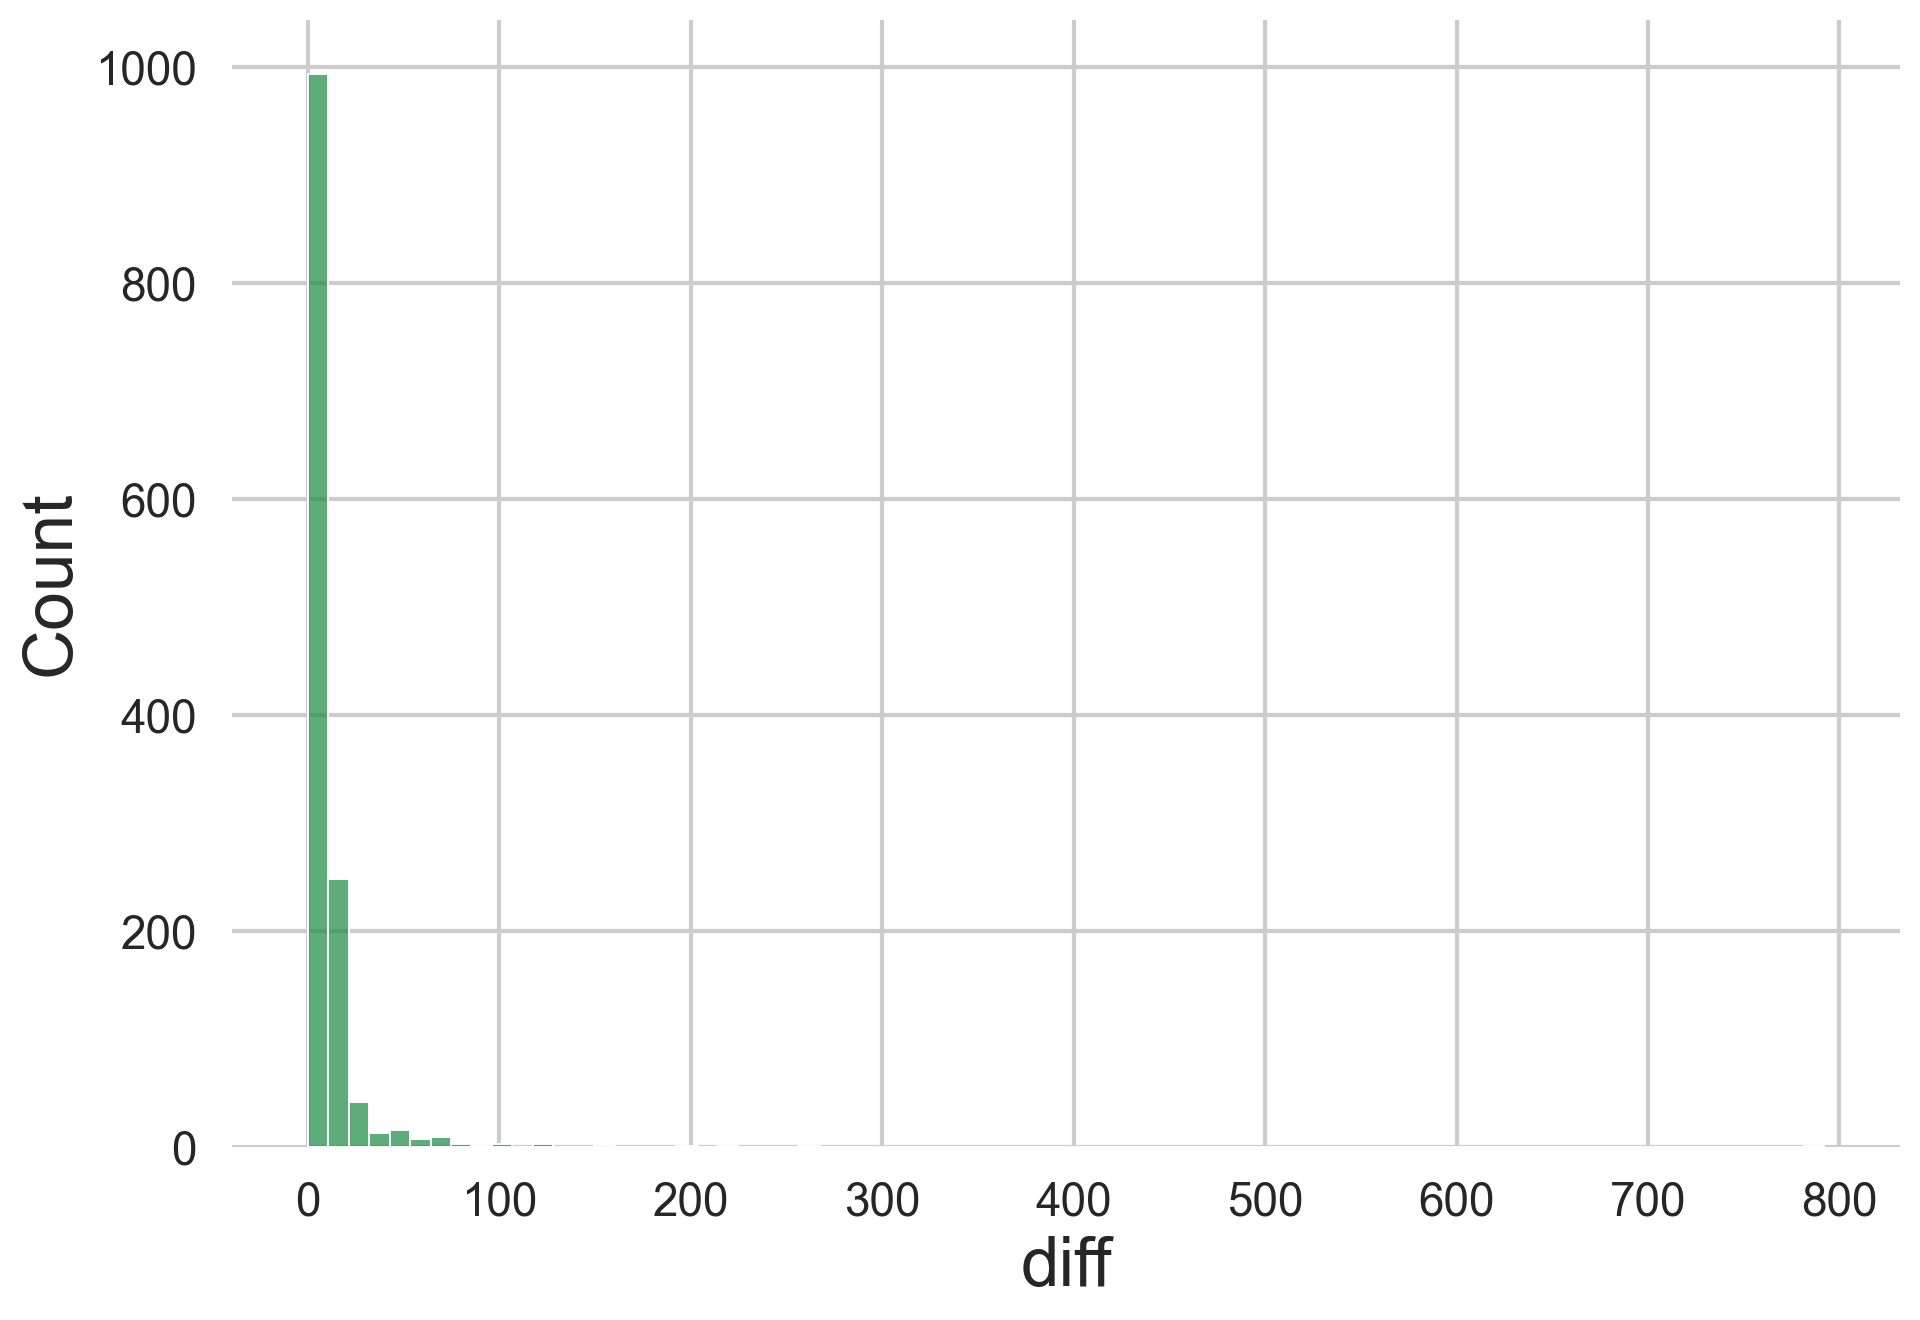

In [7]:
sns.histplot(union, x="diff")

F-statistic: 14.89494320920595
p-value: 4.878346370358518e-23


<Axes: xlabel='cluster_hdbscan', ylabel='weekly_milking_per_cow'>

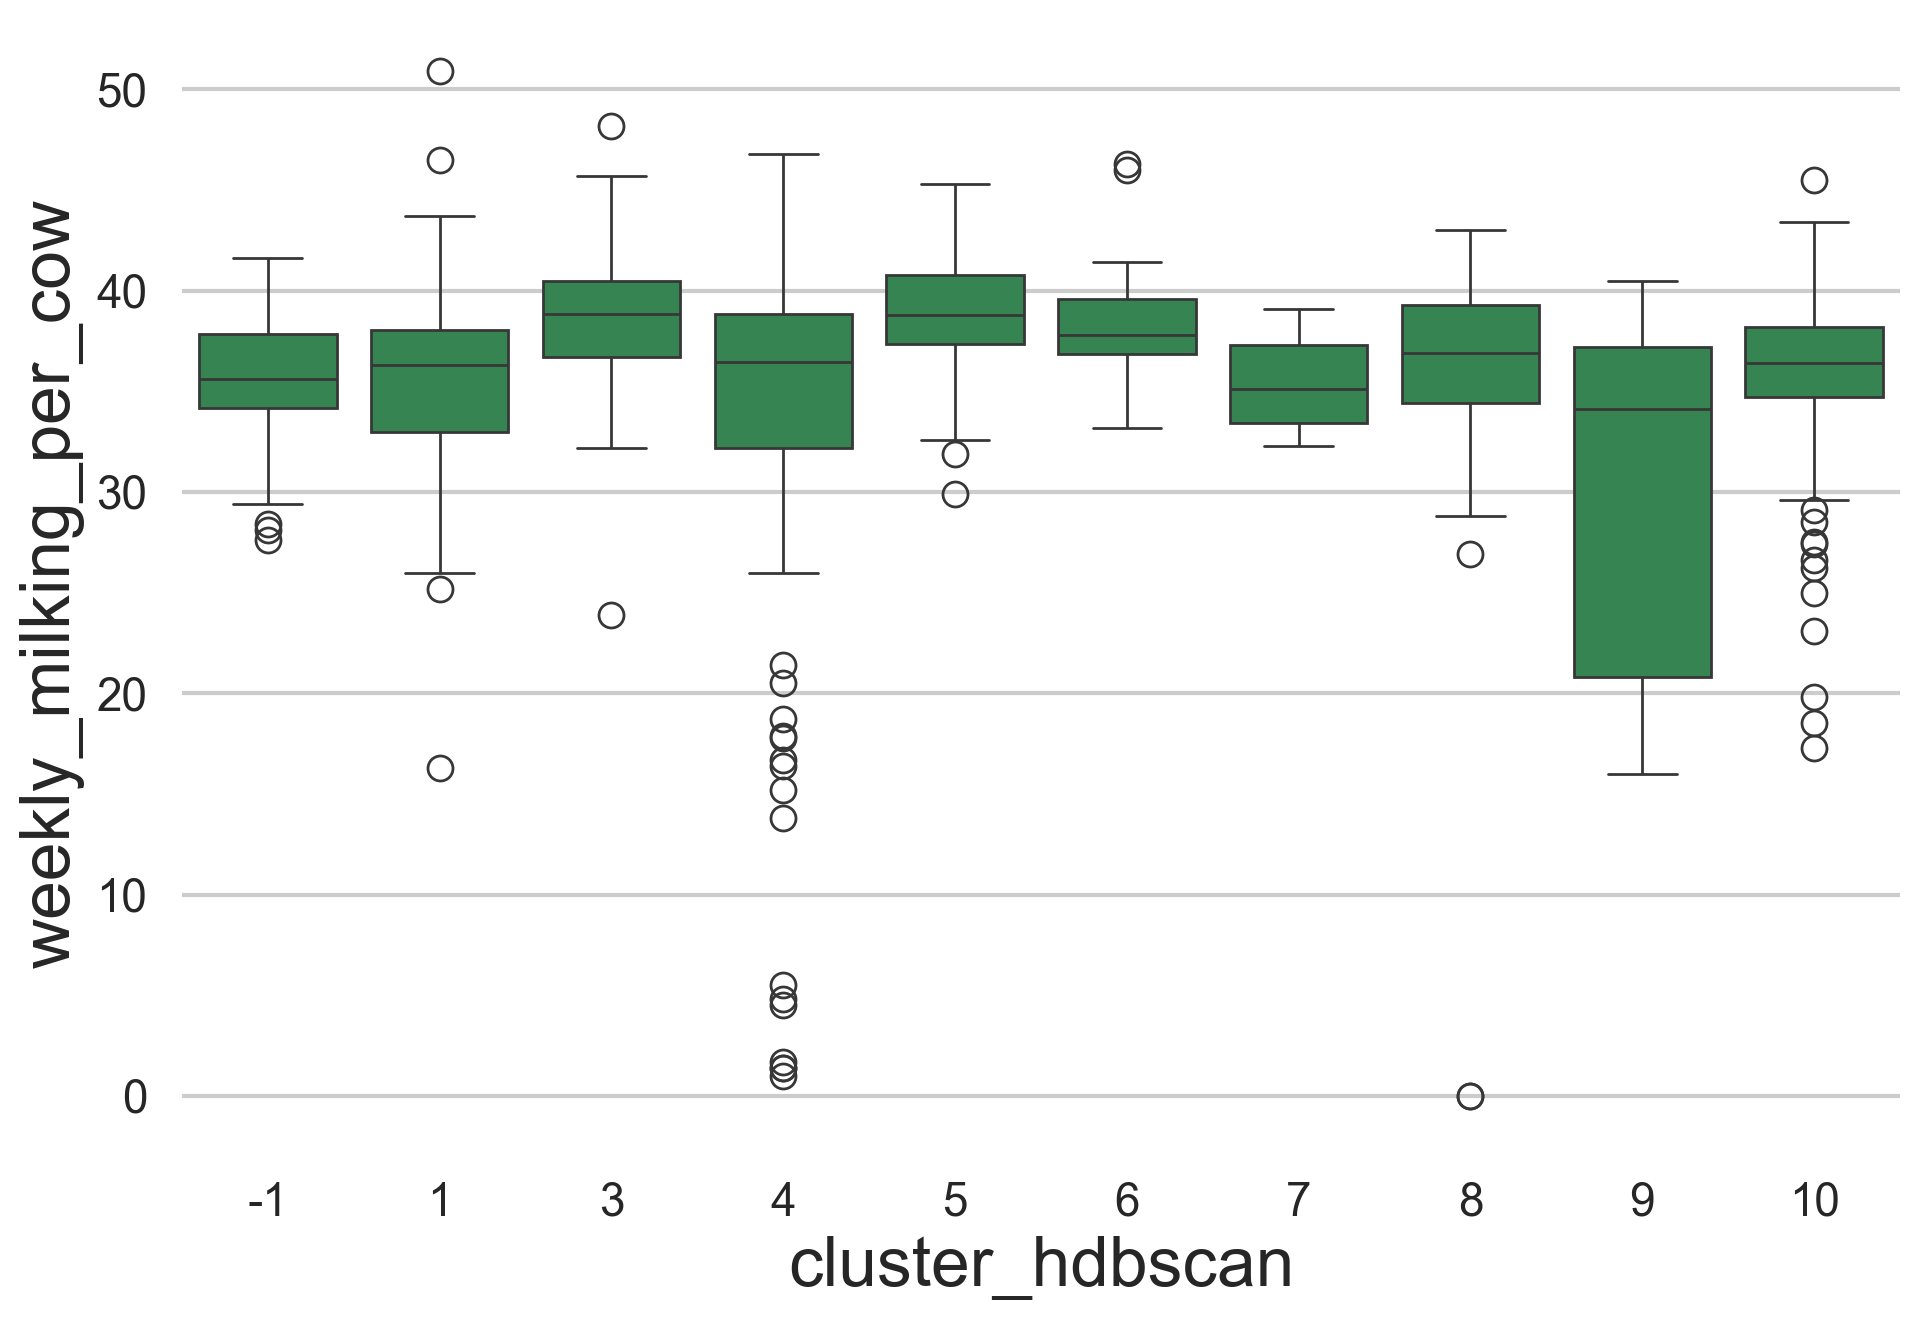

In [25]:
from scipy.stats import f_oneway

div_vectors = pd.read_csv("monthly_div_vectors.csv", index_col=0)
production_indicators["year_month"] = (production_indicators["date"]).dt.to_period('M').astype(str)
milking_feeding = pd.merge(production_indicators, div_vectors.rename(columns={"FarmName": "farm_name"}), on=["year_month", "farm_name"])
milking_feeding

groups = [
    g["weekly_milking_per_cow"].dropna().values
    for _, g in milking_feeding.groupby("cluster_hdbscan")
]

f_stat, p_val = f_oneway(*groups)

print("F-statistic:", f_stat)
print("p-value:", p_val)

sns.boxplot(data=milking_feeding, x="cluster_hdbscan", y="weekly_milking_per_cow")


In [30]:
milking_feeding[milking_feeding["cluster_hdbscan"] == 0]

,date,region,prod_farm_name,farm_type,farm_name,cows_total,milk_cows,milk_cows_d0,milk_cows_d1,milk_cows_d2,milk_cows_d3,weekly_milking_per_cow,gross_milk_yield,cow_retired,cow_retired_low_prod,cow_retired_hooves,cow_retired_inj_joint,cow_retired_mastit,cow_retired_jkt,bull_num,year_month,Белковые корма,Жидкости,Жиры и глюкозогенные добавки,Жом и дробина,Комбикорма и стартеры,Минералы/буферные,Объёмные корма,Остатки,"Премиксы, БАДы, дрожжи",Энергетические и крахмалистые корма,dist_to_center_euclid,dist_to_center_manhattan,um1,um2,cluster_hdbscan,cluster_dbscan


In [26]:
div_vectors.groupby("cluster_hdbscan")["FarmName"].count()

cluster_hdbscan
-1      45
 0      26
 1     153
 2      41
 3     227
 4     426
 5      53
 6      27
 7      47
 8     247
 9      37
 10    296
Name: FarmName, dtype: int64

In [27]:
print(pg.anova(milking_feeding, dv="weekly_milking_per_cow", between="cluster_hdbscan"))

pg.pairwise_gameshowell(milking_feeding, dv="weekly_milking_per_cow", between="cluster_hdbscan")



            Source  ddof1  ddof2          F         p-unc       np2
0  cluster_hdbscan      9   1120  14.894943  4.878346e-23  0.106897


,A,B,mean(A),mean(B),diff,se,T,df,pval,hedges
0,-1,1,35.468421,35.322321,0.146100,0.702400,0.208000,88.108756,1.000000e+00,0.033232
1,-1,3,35.468421,38.512048,-3.043627,0.599217,-5.079340,52.720339,2.052613e-04,-0.951136
2,-1,4,35.468421,34.780921,0.687500,0.682579,1.007209,86.300359,9.910901e-01,0.100782
3,-1,5,35.468421,38.910000,-3.441579,0.679712,-5.063293,72.037702,1.270566e-04,-1.105297
4,-1,6,35.468421,38.288889,-2.820468,0.807725,-3.491868,58.994747,2.879143e-02,-0.855287
5,-1,7,35.468421,35.340000,0.128421,0.745246,0.172320,52.540137,1.000000e+00,0.041644
6,-1,8,35.468421,36.271918,-0.803497,0.697653,-1.151715,88.867223,9.775088e-01,-0.163019
7,-1,9,35.468421,29.718919,5.749502,1.468467,3.915310,47.349897,9.802627e-03,0.903662
8,-1,10,35.468421,36.026087,-0.557666,0.599192,-0.930697,52.841802,9.946607e-01,-0.152052
9,1,3,35.322321,38.512048,-3.189727,0.503465,-6.335549,178.374408,8.362027e-08,-0.831189


In [35]:
production_indicators["year_month"].unique()

array(['2022-12', '2023-01', '2023-02', '2023-03', '2023-04', '2023-05',
       '2023-06', '2023-07', '2023-08', '2023-09', '2023-10', '2023-11',
       '2023-12', '2024-01', '2024-02', '2024-03', '2024-04', '2024-05',
       '2024-06', '2024-07', '2024-08', '2024-09', '2024-10', '2024-11',
       '2024-12', '2025-01', '2025-02', '2025-03', '2025-04', '2025-05',
       '2025-06', '2025-07'], dtype=object)

In [38]:
div_vectors

,FarmName,↑ Белковые корма (повышение надоя и % белка молока),↑ Жиры и глюкозогенные добавки (увеличение энергии – ↑ надой),↑ Источники энергии и крахмала (повышение надоя),↑ Комбикорма/стартеры/БВМК (повышение продуктивности),"↑ Премиксы, БАДы, дрожжи (повышение надоя/конверсии)","→ Жом, дробина (нейтрально/умеренно ↑)","→ Минералы/буферные (нейтрально, стаб. румена)",→ Объёмные корма (нейтрально/зависит от качества),"→ Сенаж/сено/солома (нейтрально, при дефиците ↓)",dist_to_center_euclid,dist_to_center_manhattan,um1,um2,cluster_hdbscan
year_month,,,,,,,,,,,,,,,
2022-01,ЖК Добрино,3.959307,0.104307,4.264567,2.368581,0.0,0.000000,0.097372,18.136432,5.109616,2.049109,3.843448,7.036275,7.278438,-1
2022-01,ЖК Коршево,3.713780,0.130531,3.459659,2.838079,0.0,0.000000,0.000000,13.740230,5.184947,2.236767,5.312565,7.113742,7.356750,-1
2022-02,ЖК Бодеевка,4.054455,0.082931,3.713490,2.405424,0.0,0.000000,0.034652,16.072685,4.709940,2.277357,4.715500,7.079598,7.339309,-1
2022-02,ЖК Верхний Икорец,3.325421,0.081664,4.203870,2.529503,0.0,0.000000,0.000000,13.654614,8.031499,1.592585,3.751260,9.910605,9.016972,5
2022-02,ЖК Высокое,4.707636,0.129009,4.675270,2.965223,0.0,0.000000,0.264720,18.165895,5.508462,2.267828,5.436595,6.649373,6.993750,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-10,МТФ Гилево,1.792810,0.000000,29.440213,0.000000,0.0,2.144341,0.281732,0.000000,18.779228,7.909114,16.705404,3.875082,0.847767,-1
2025-10,МТФ Каширинское,7.954037,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,41.610455,15.575776,4.112018,11.278405,9.782794,-6.985783,-1
2025-10,МТФ Романово,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,30.906191,23.320120,4.948405,12.986668,8.589643,-0.272299,-1


In [23]:
features = ['Объёмные корма', 'Энергетические и крахмалистые корма', 'Белковые корма', 'Жиры и глюкозогенные добавки', 'Комбикорма и стартеры', 'Премиксы, БАДы, дрожжи', 'Жом и дробина', 'Минералы/буферные', 'Жидкости', 'Остатки']
features_1 = ['forage_bulk', 'energy_source', 'protein_source', 'fat_oils', 'yeast_products', 'compound_feed_calf_replacements', 'premix_feed', 'byproducts', 'wet_ingredients_water', 'minerals_buffers', 'medications']

In [31]:
div_vectors.groupby("cluster_hdbscan")[features].mean()

,Объёмные корма,Энергетические и крахмалистые корма,Белковые корма,Жиры и глюкозогенные добавки,Комбикорма и стартеры,"Премиксы, БАДы, дрожжи",Жом и дробина,Минералы/буферные,Жидкости,Остатки
cluster_hdbscan,,,,,,,,,,
-1,29.660669,4.696194,4.710916,0.148810,4.486289,0.020436,0.258038,0.033947,4.599388,27.169657
0,54.331995,0.000000,7.807039,0.000000,0.000000,0.006886,1.115069,0.000000,0.000000,0.000000
1,27.589266,7.741644,4.413502,0.000000,5.241916,0.000000,0.005291,0.000000,4.469269,41.915677
2,25.752933,5.524828,4.075163,0.120570,2.922671,0.035275,0.036668,0.073608,6.203575,0.000000
3,28.127118,5.321126,4.214320,0.003432,3.509092,0.027766,1.260386,0.070899,4.682807,0.000000
4,33.102110,6.507699,3.944474,0.205438,0.047716,0.184968,1.298635,0.353386,4.121128,6.870499
5,27.163253,6.177482,4.050334,0.000000,3.360894,0.000000,1.260457,0.158279,4.447980,39.766987
6,29.555108,7.699001,4.734568,0.000000,3.797166,0.102069,1.520773,0.024627,6.618933,18.260256
7,20.013404,4.983212,3.240858,0.096124,3.183962,0.124824,2.321200,0.181077,6.366284,43.665439


In [25]:
union["forage_diff"] = abs(union["forage_cow"] - union["milk_cow"] + union["dry_cow"])

<Axes: xlabel='forage_diff', ylabel='Count'>

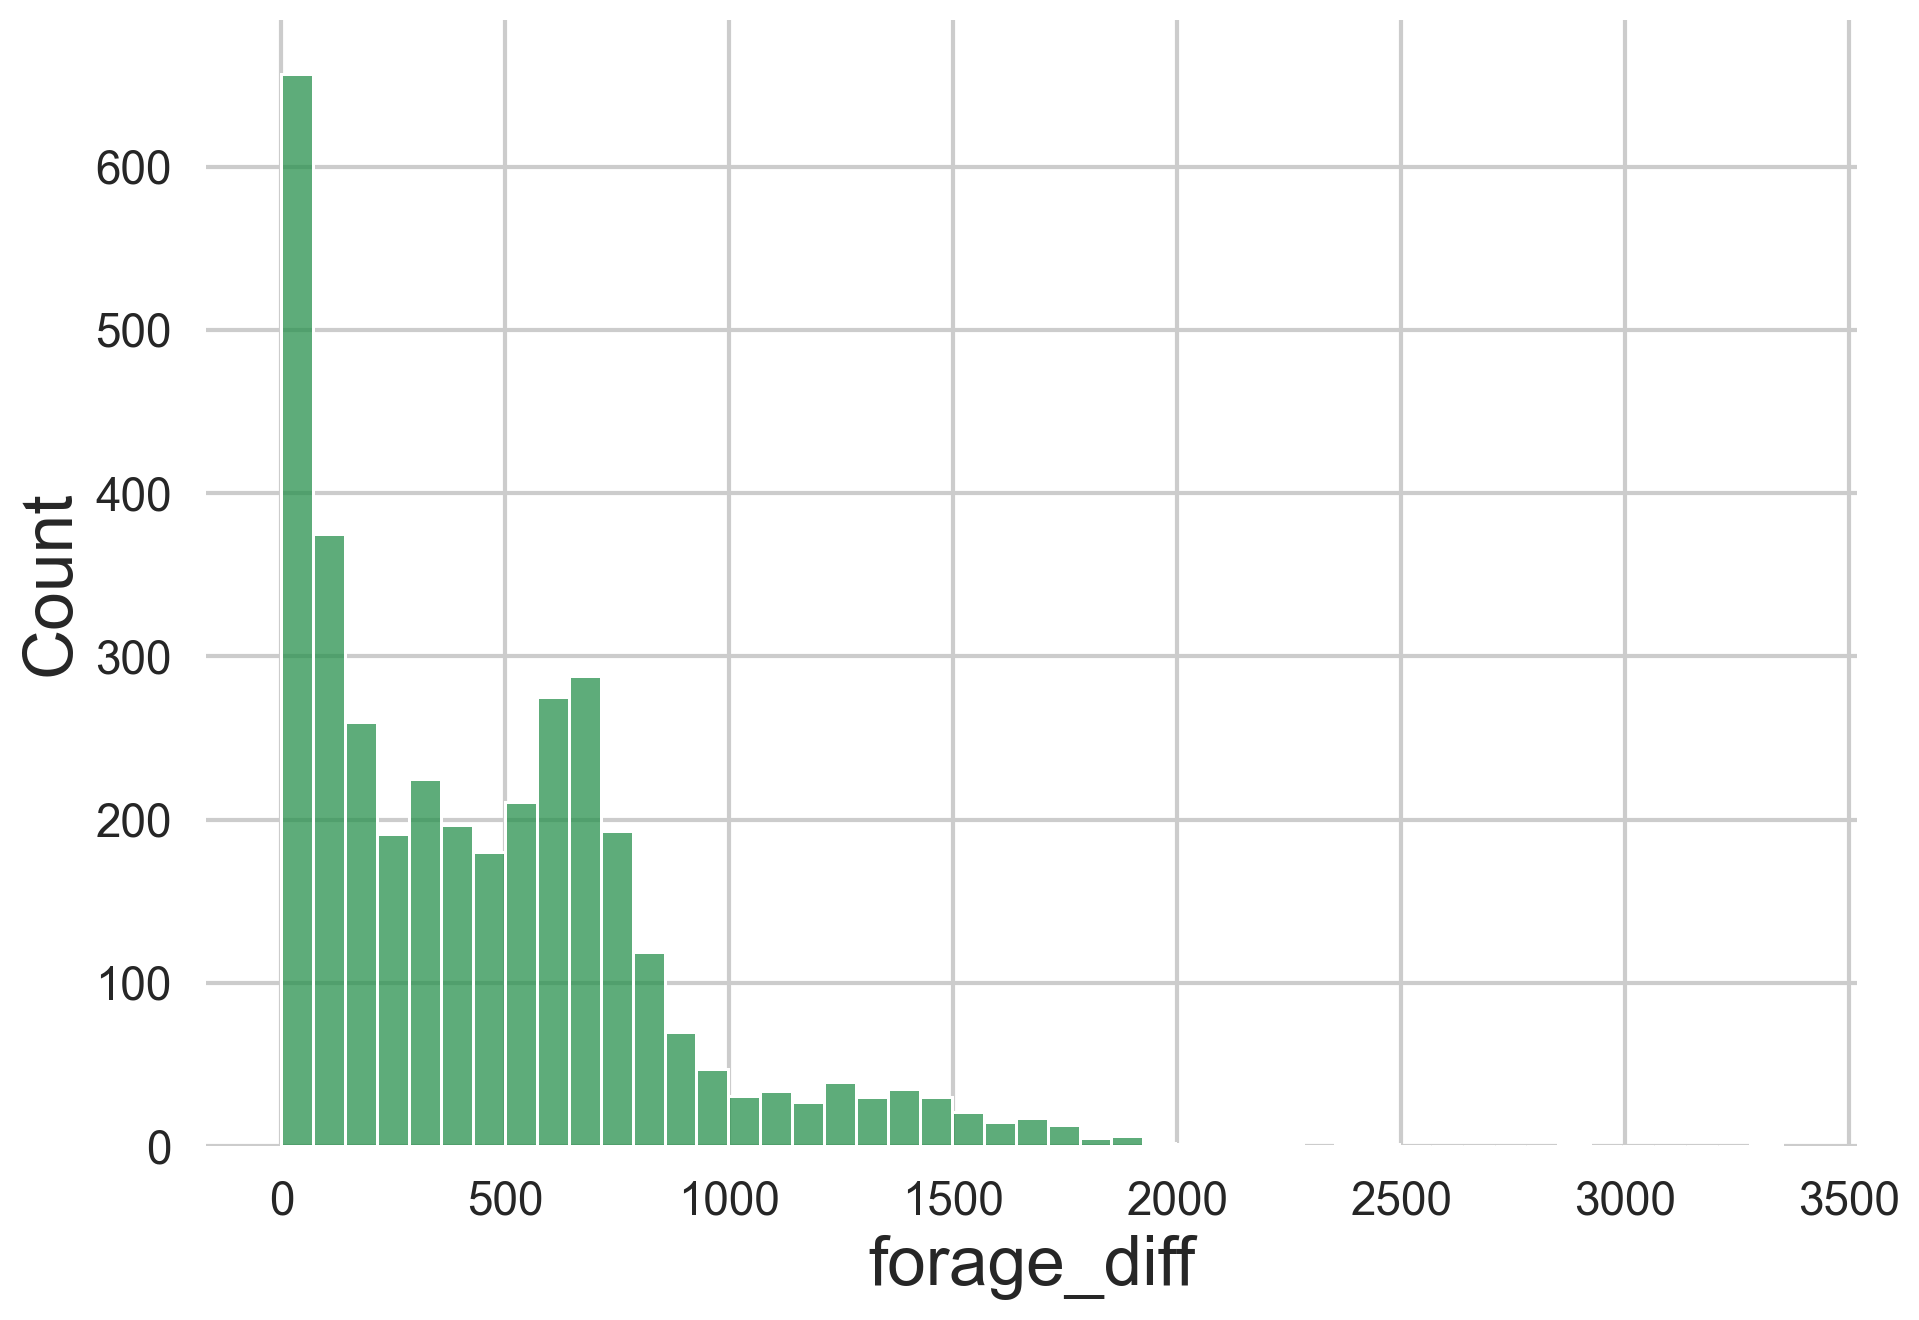

In [26]:
sns.histplot(union, x="forage_diff")

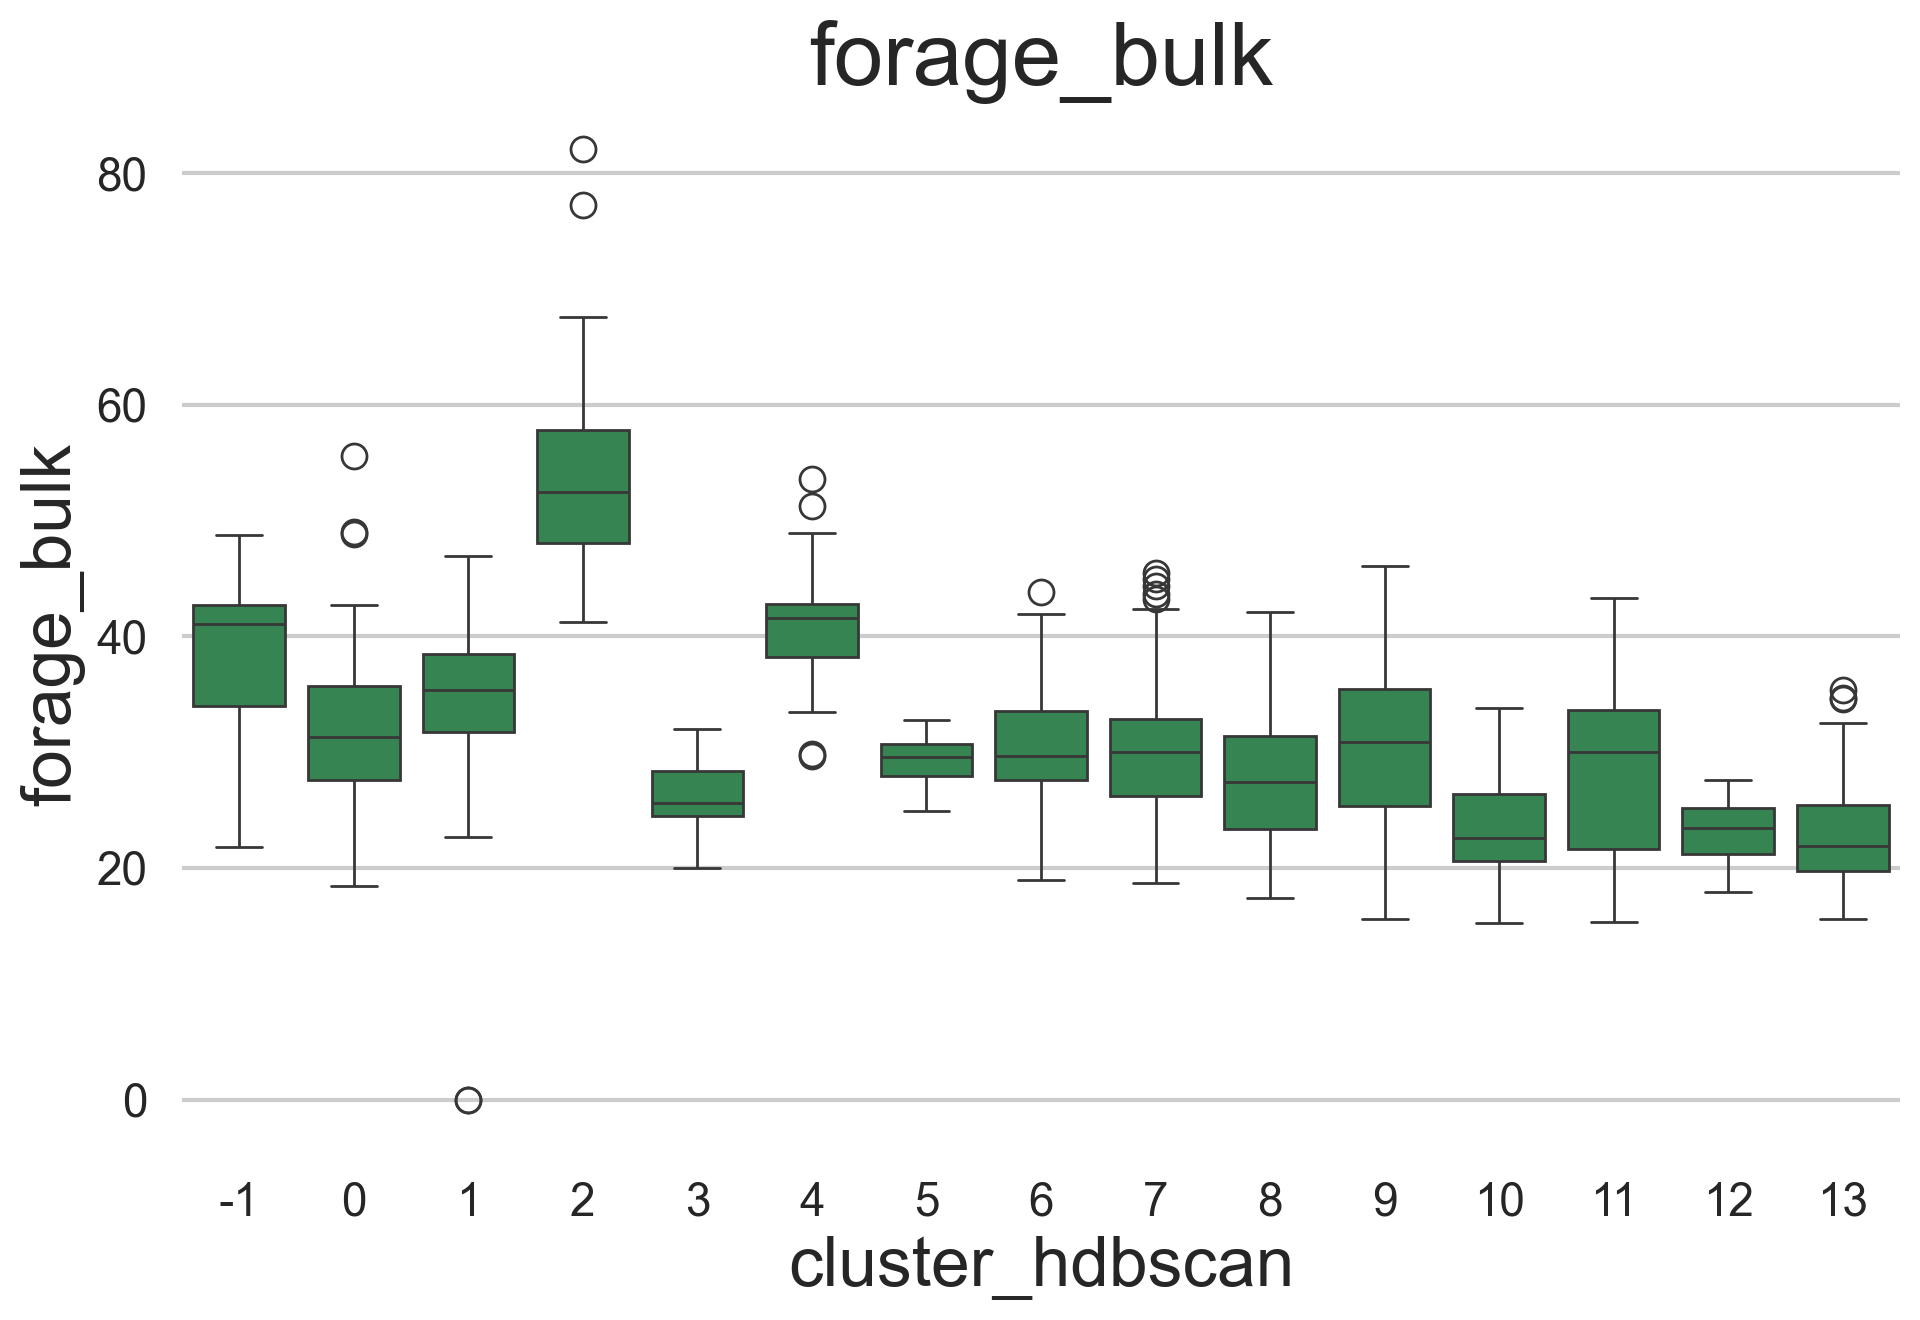

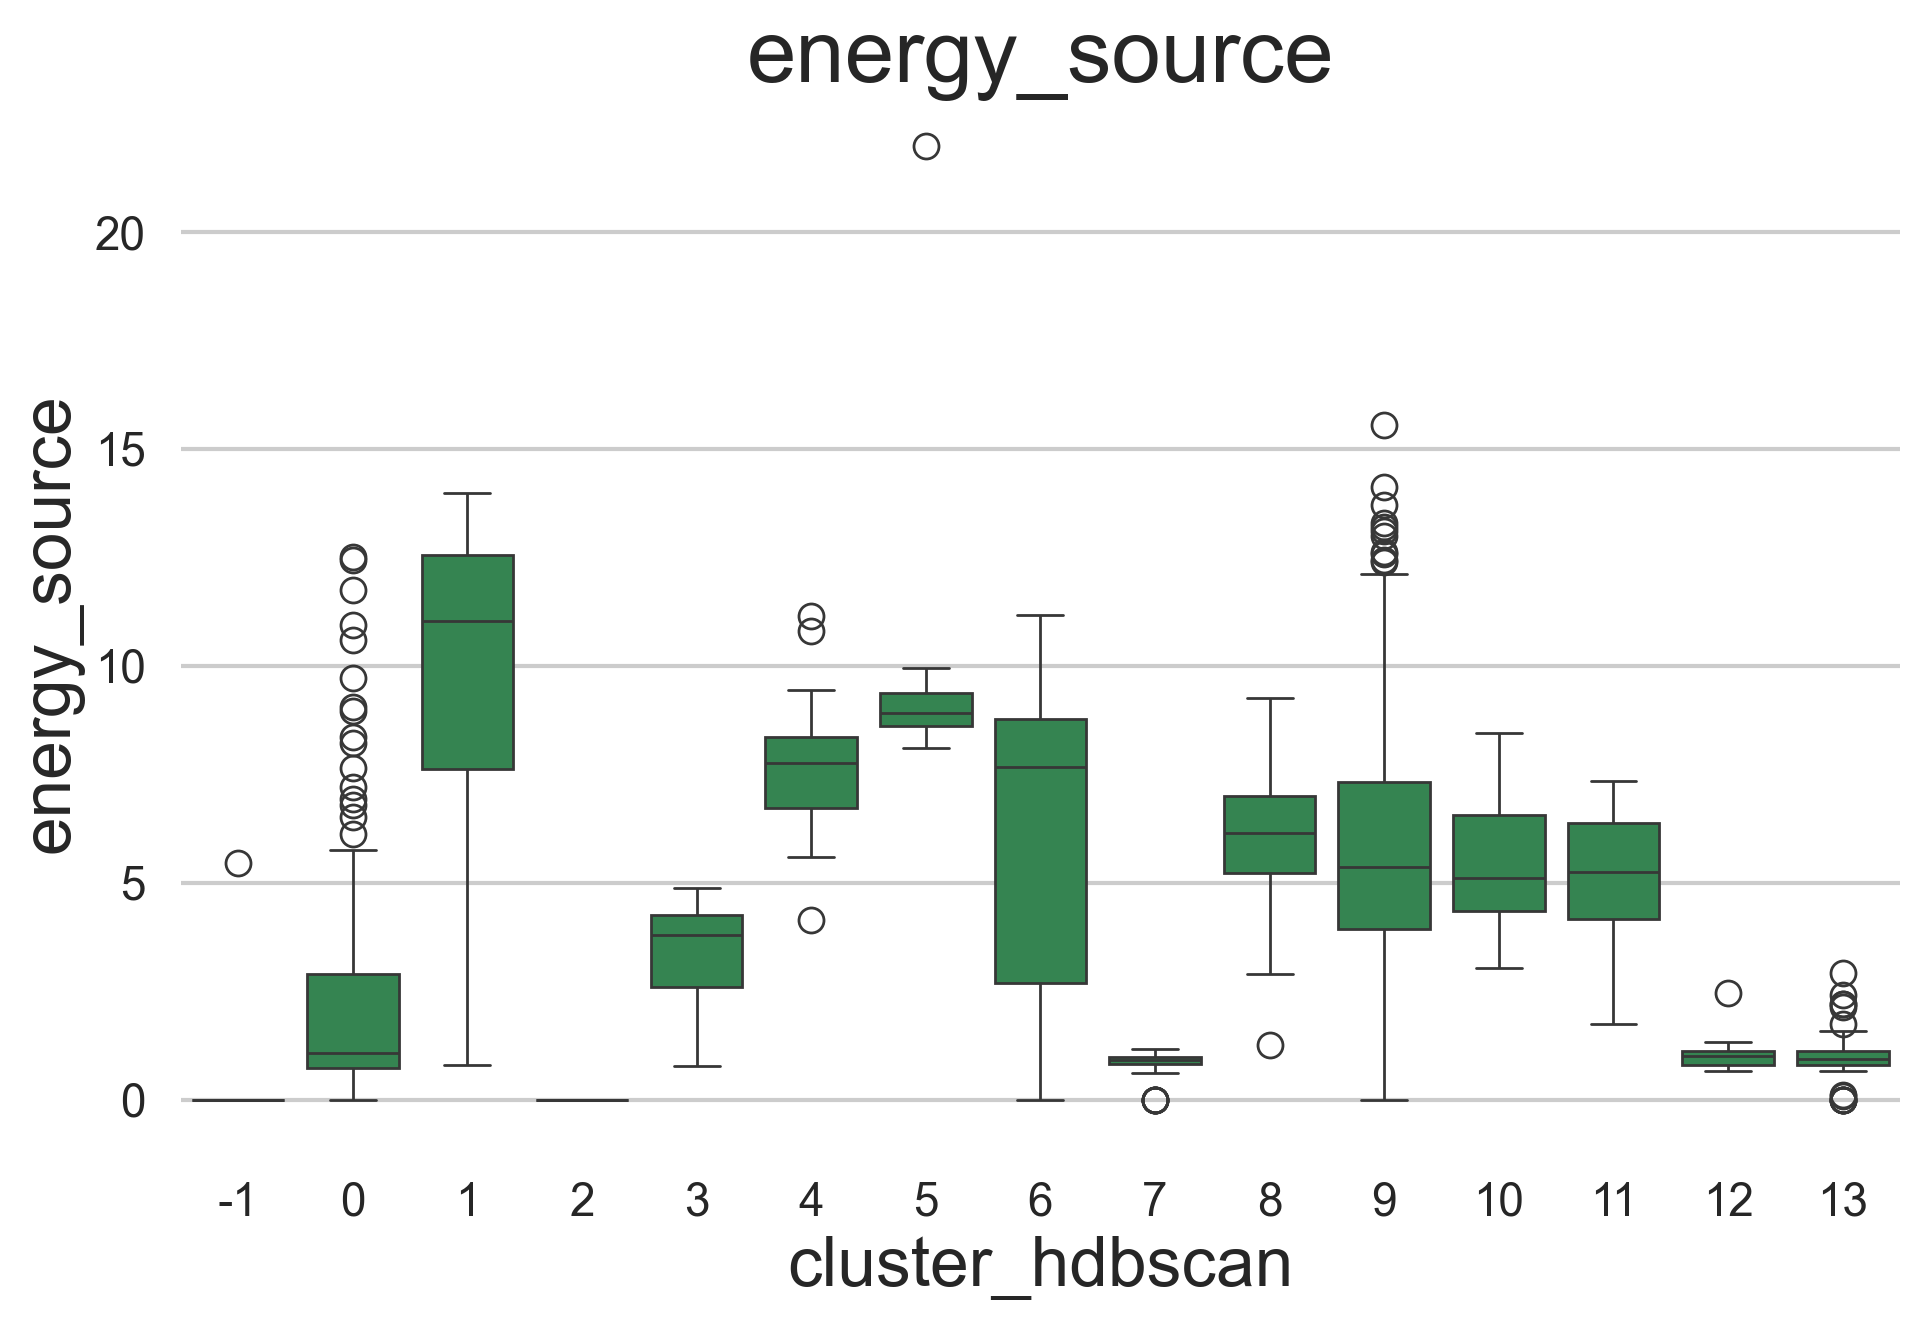

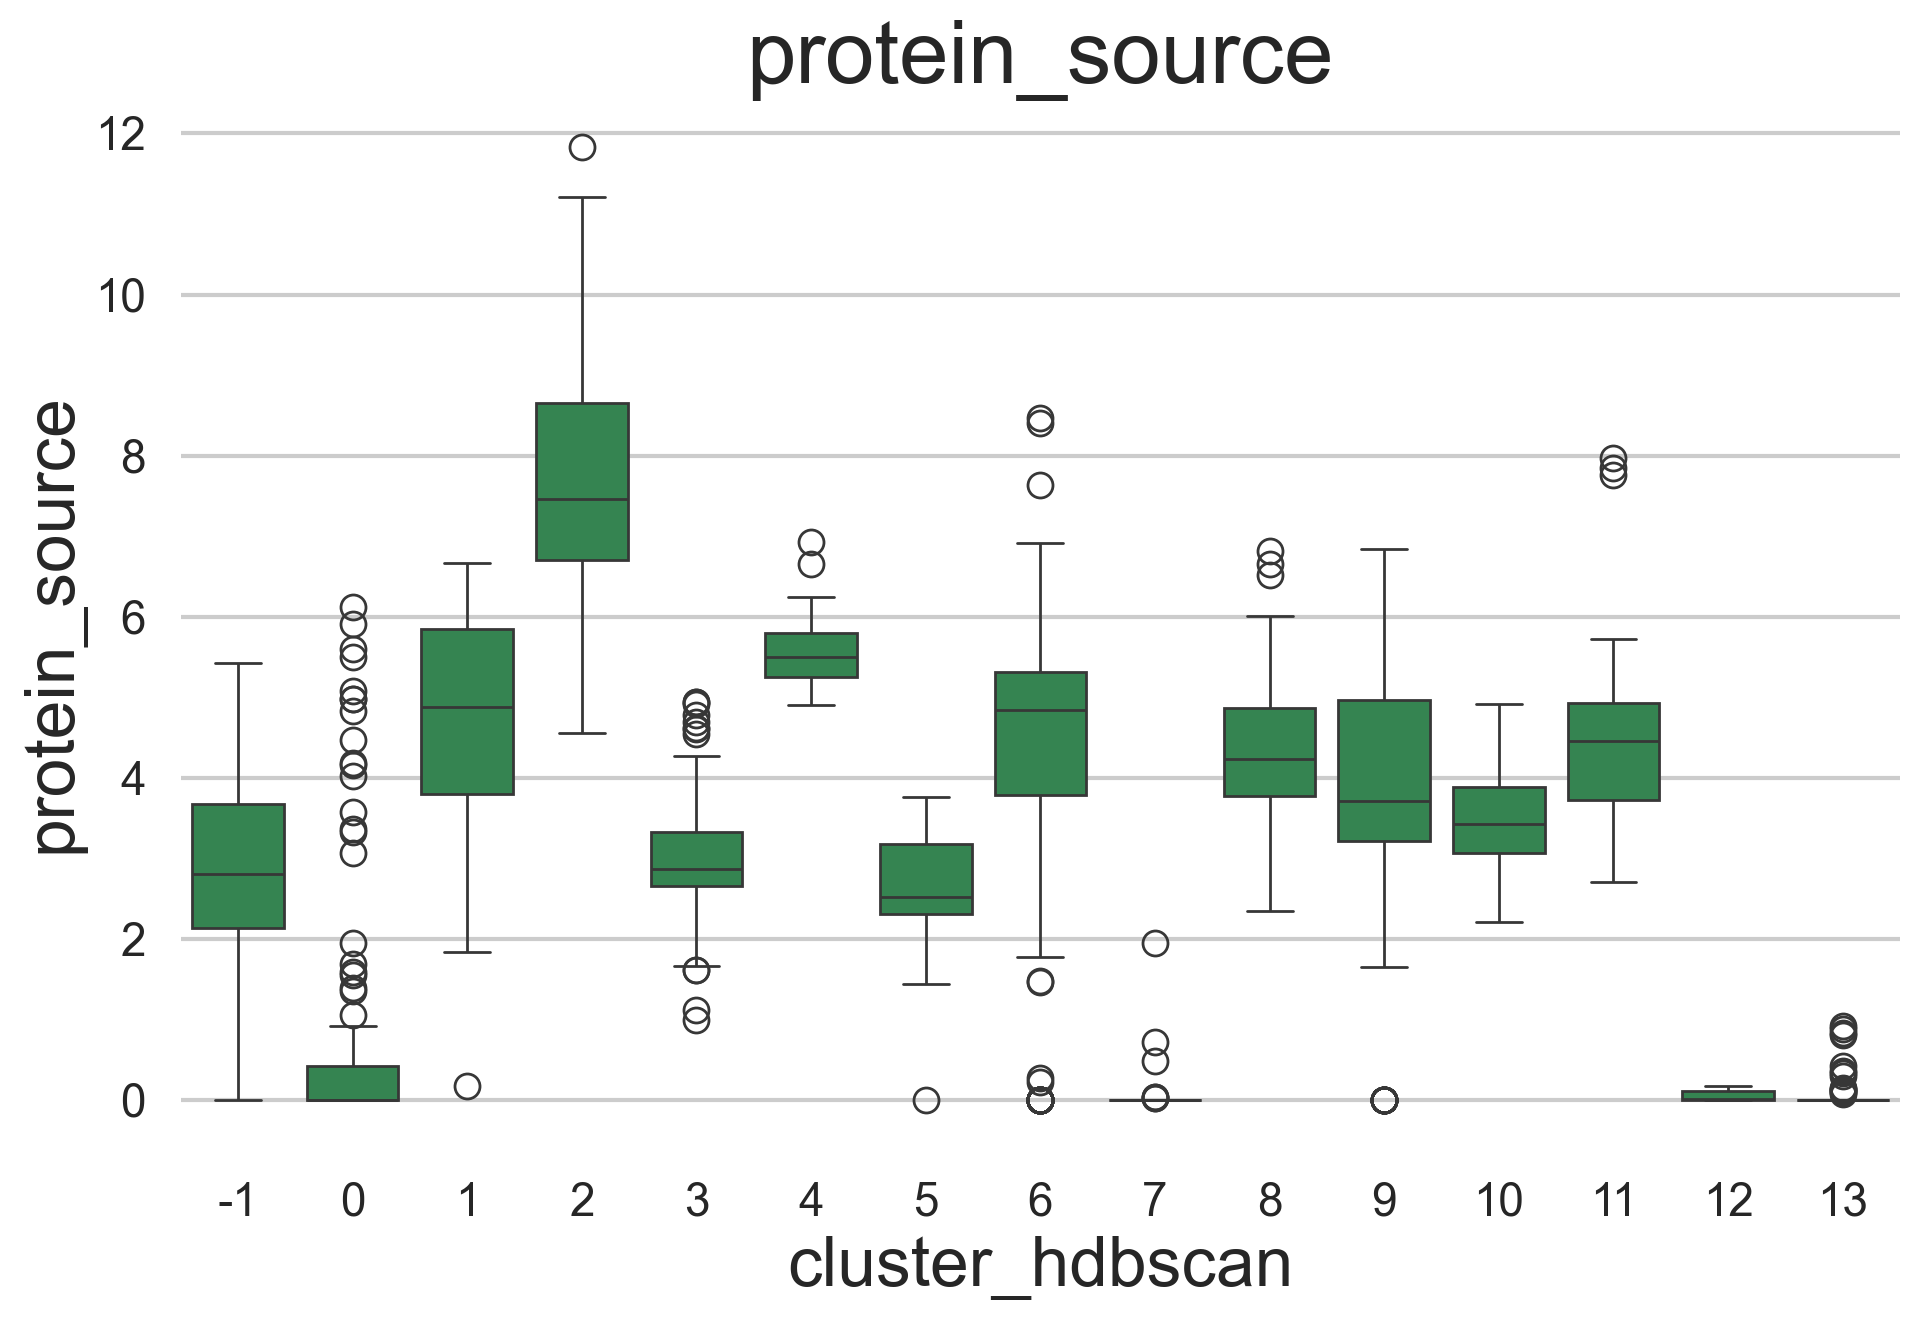

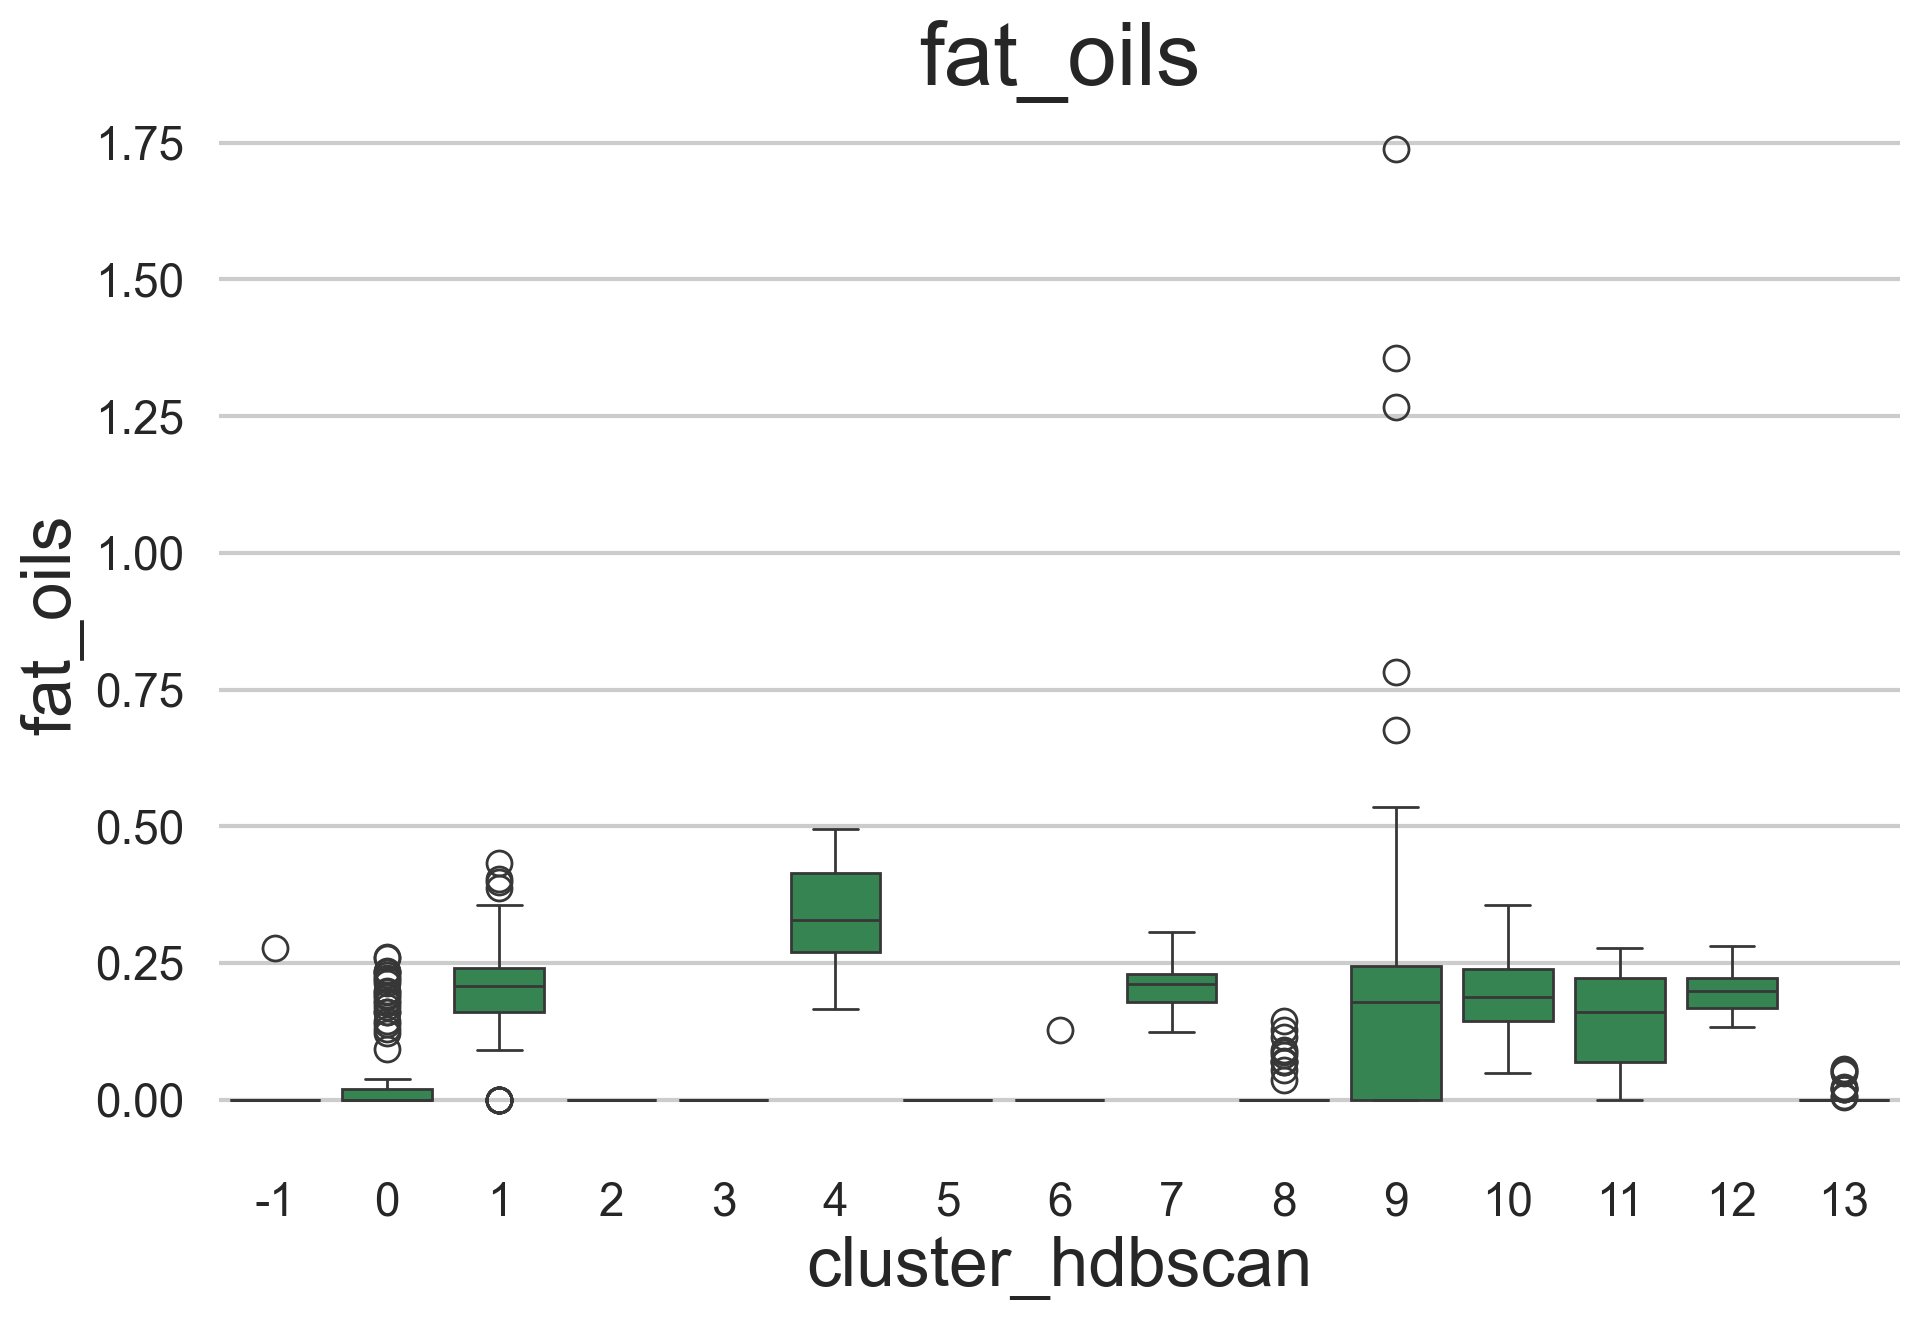

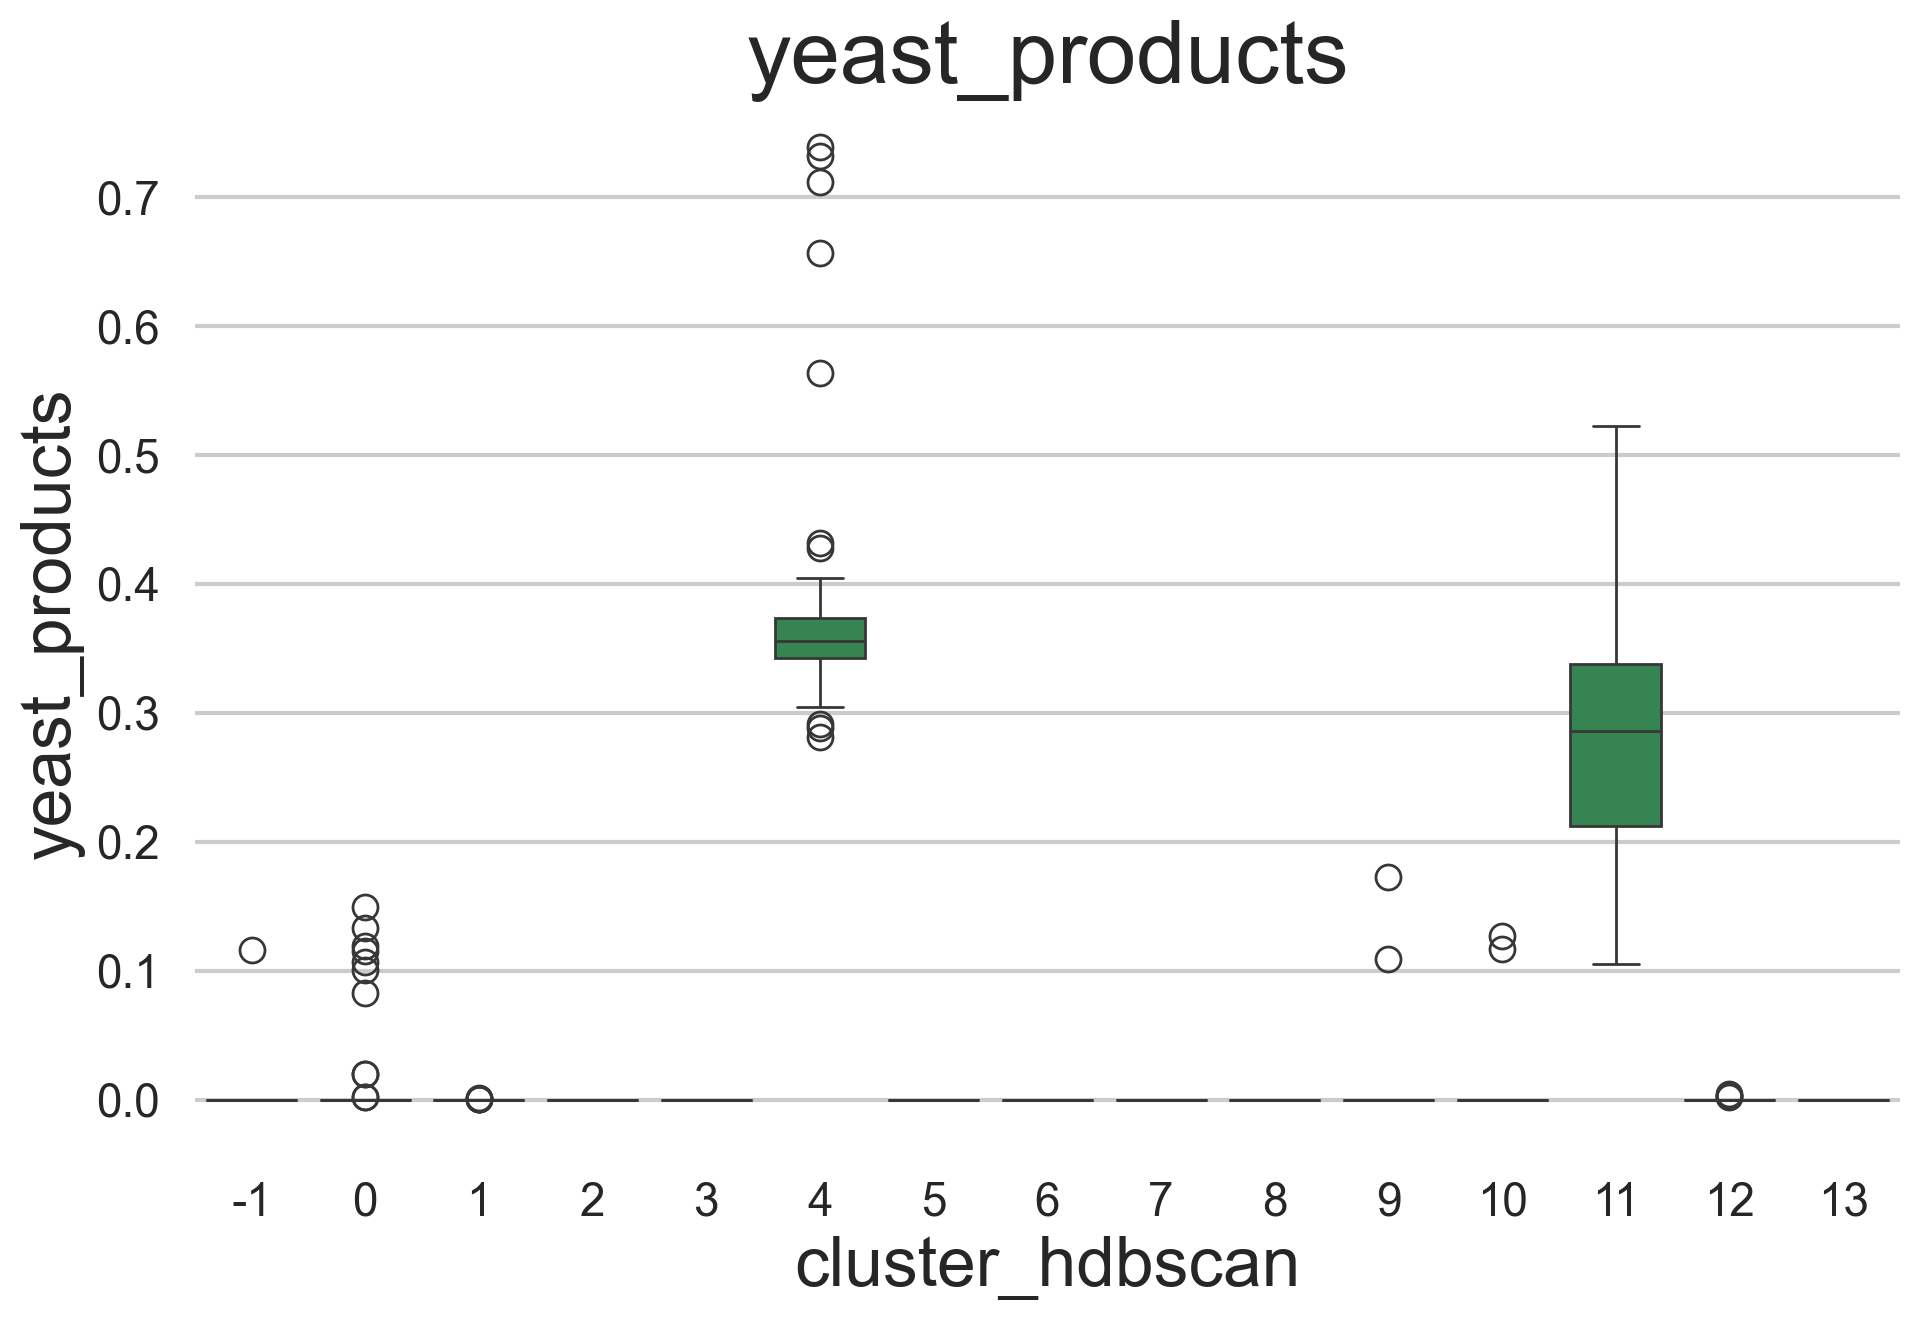

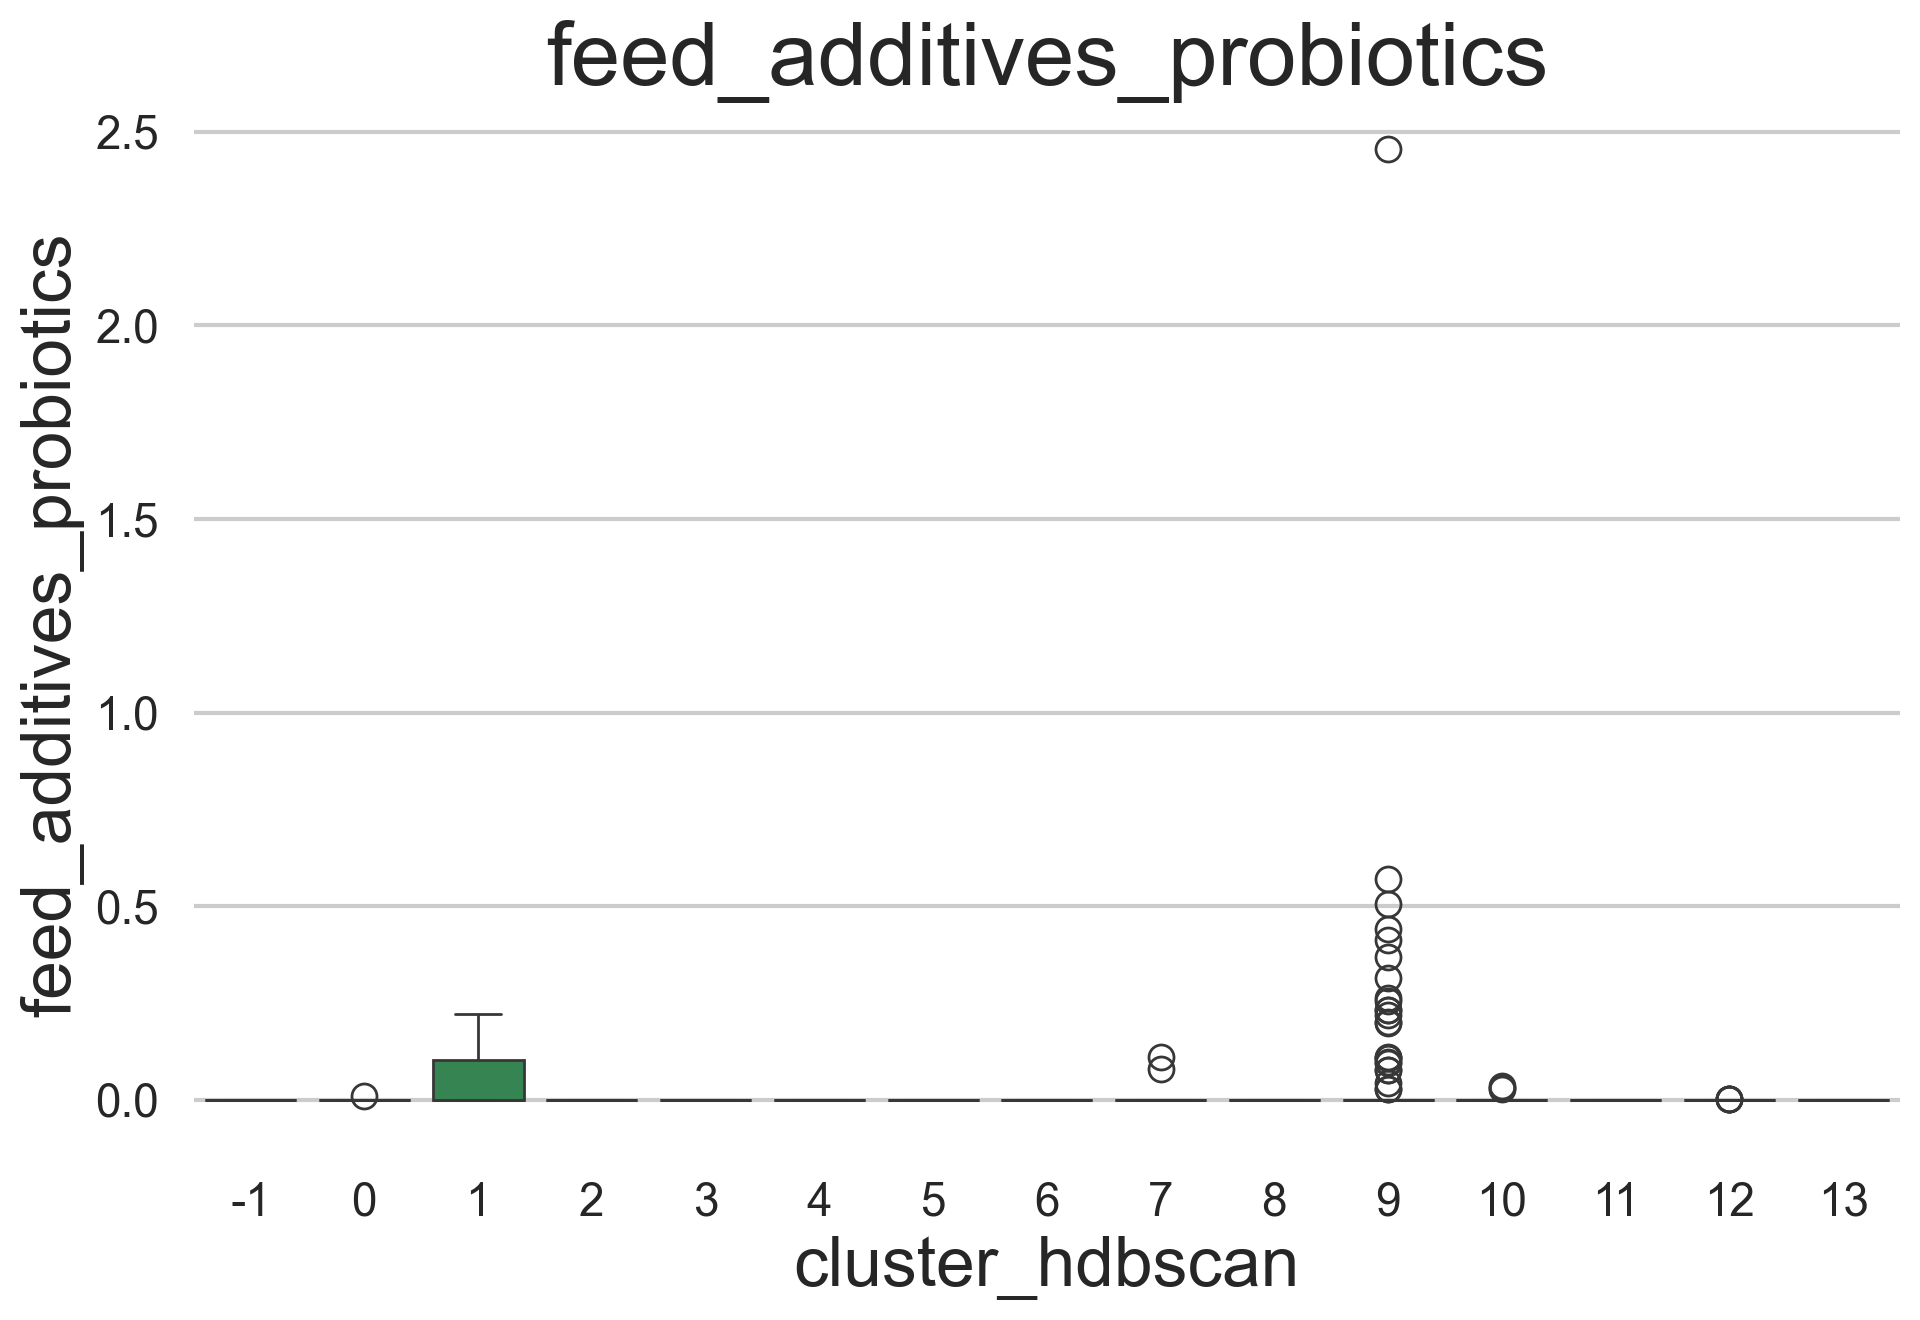

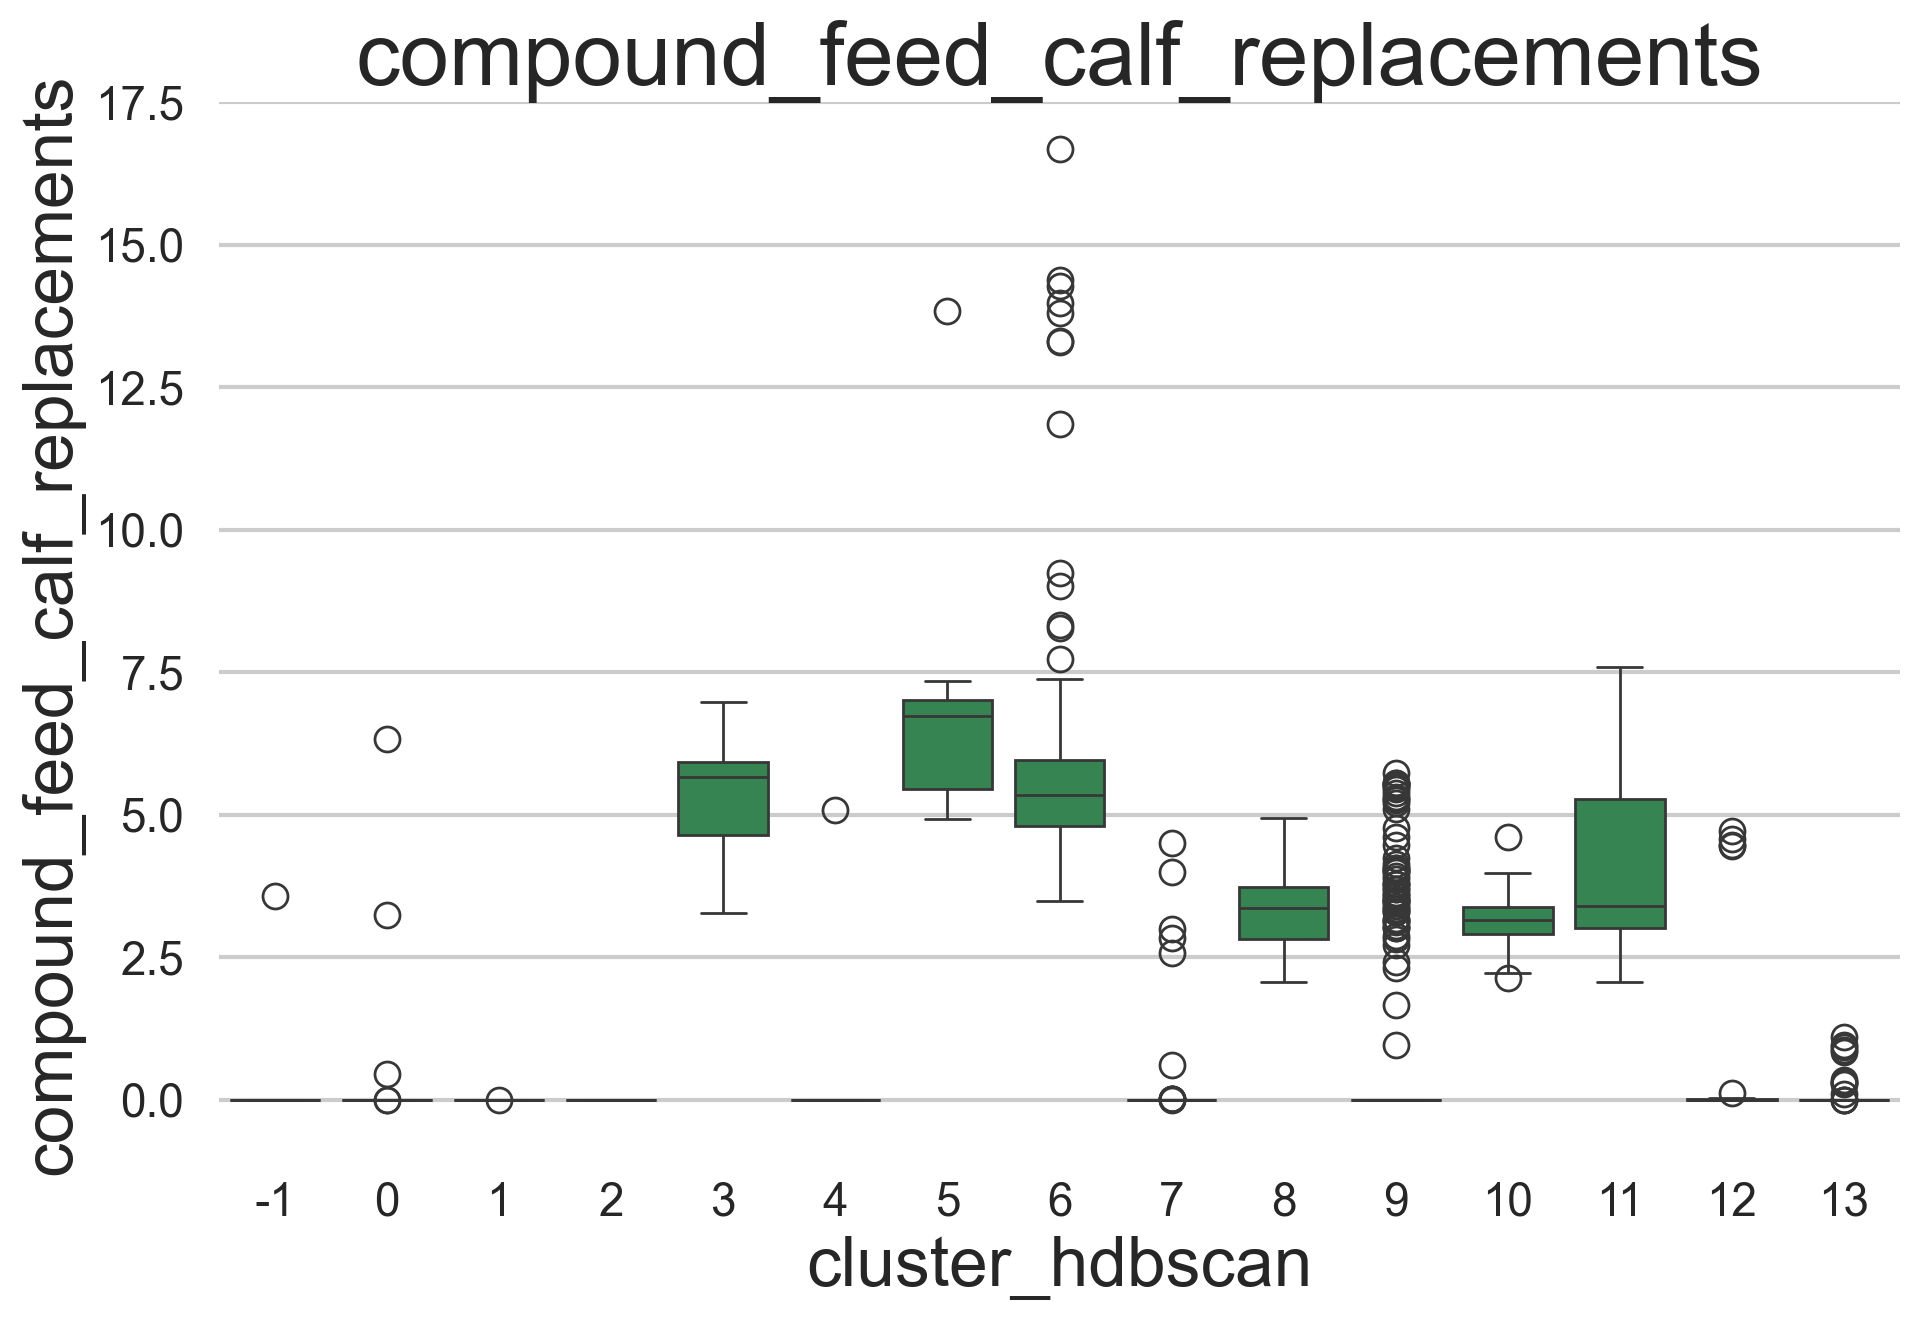

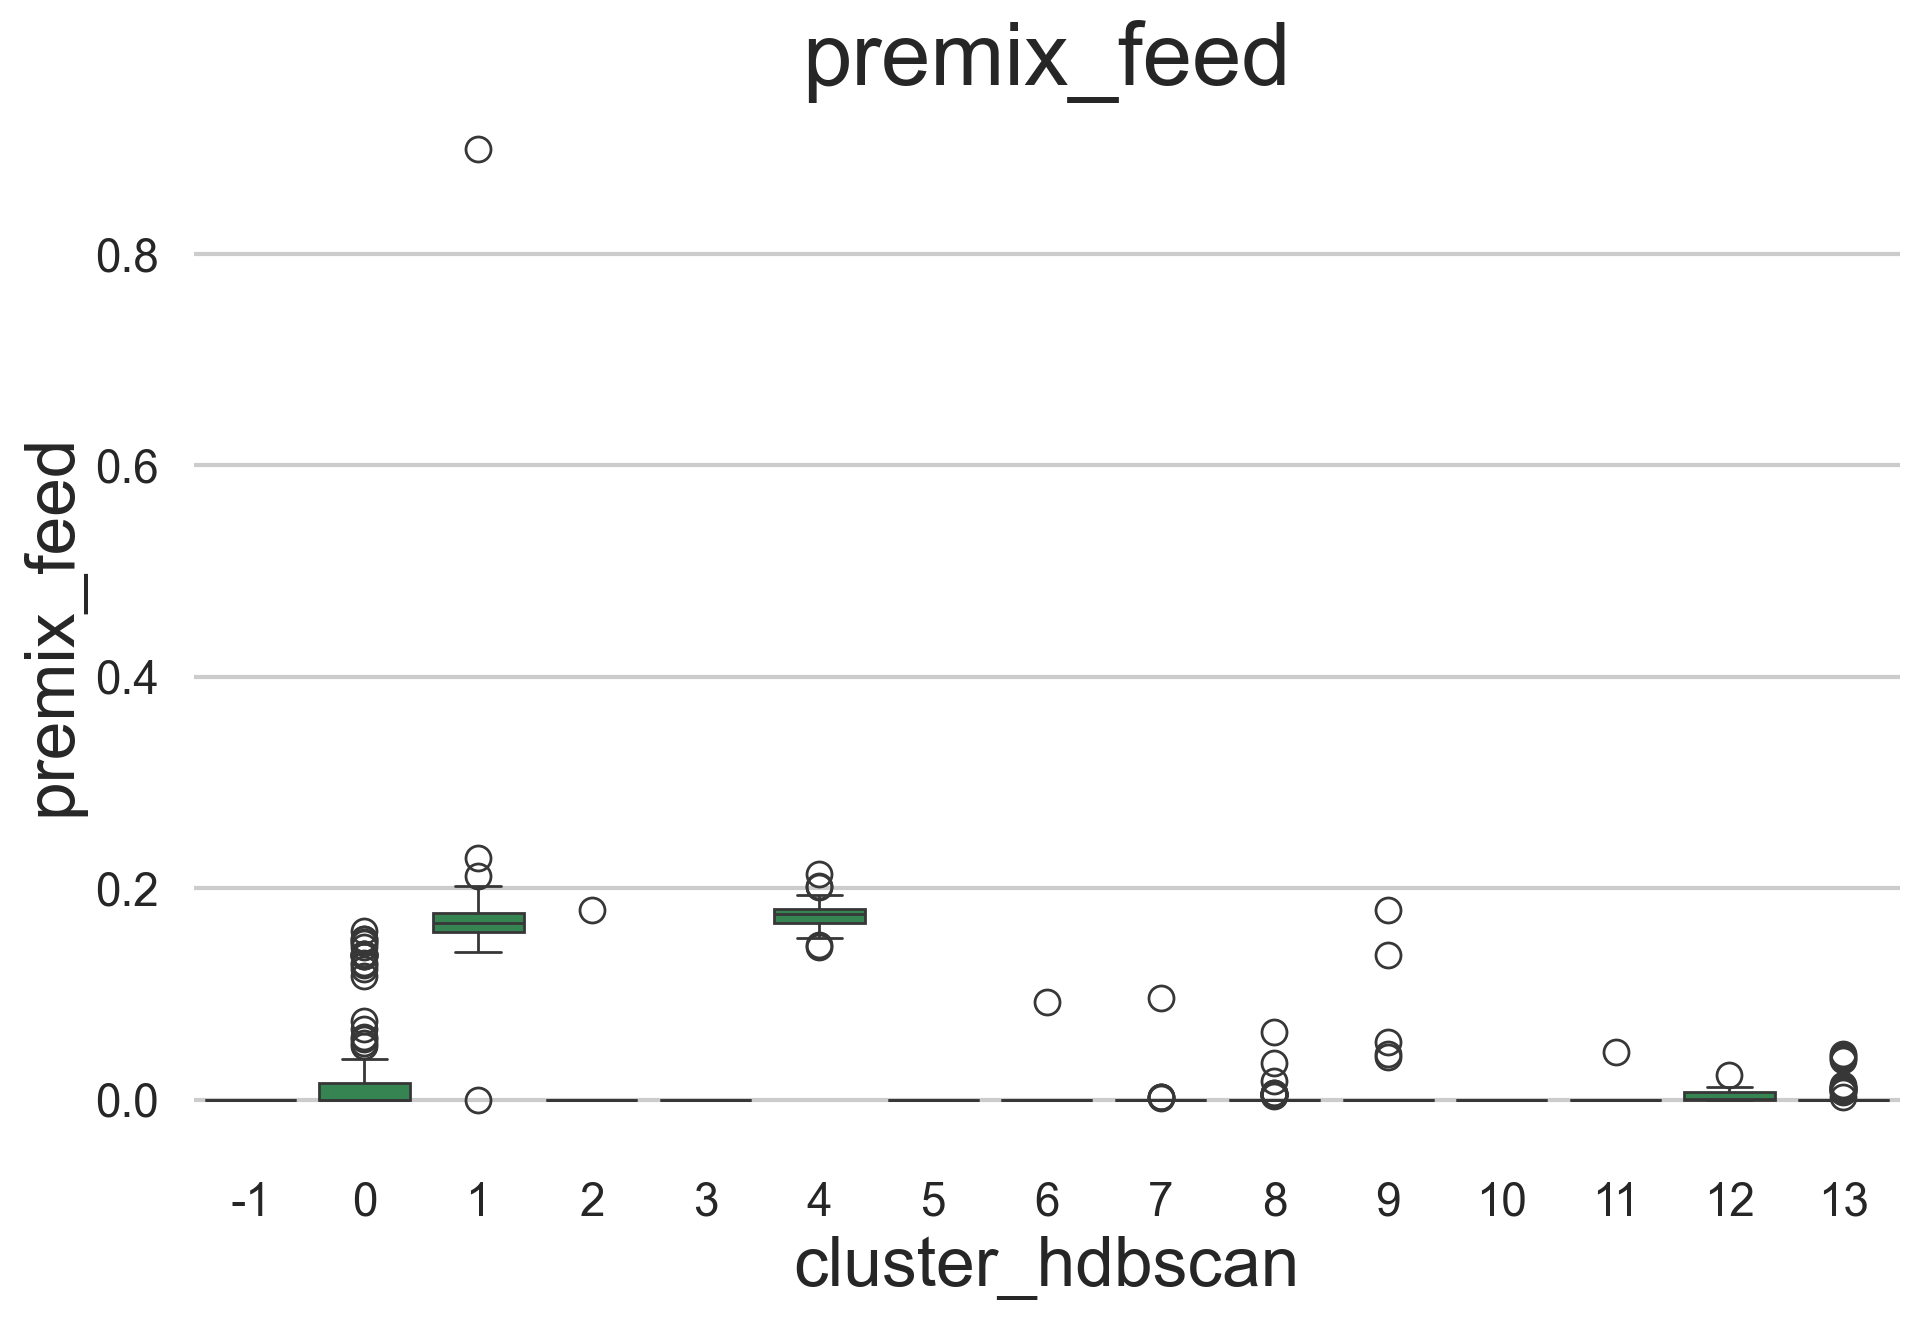

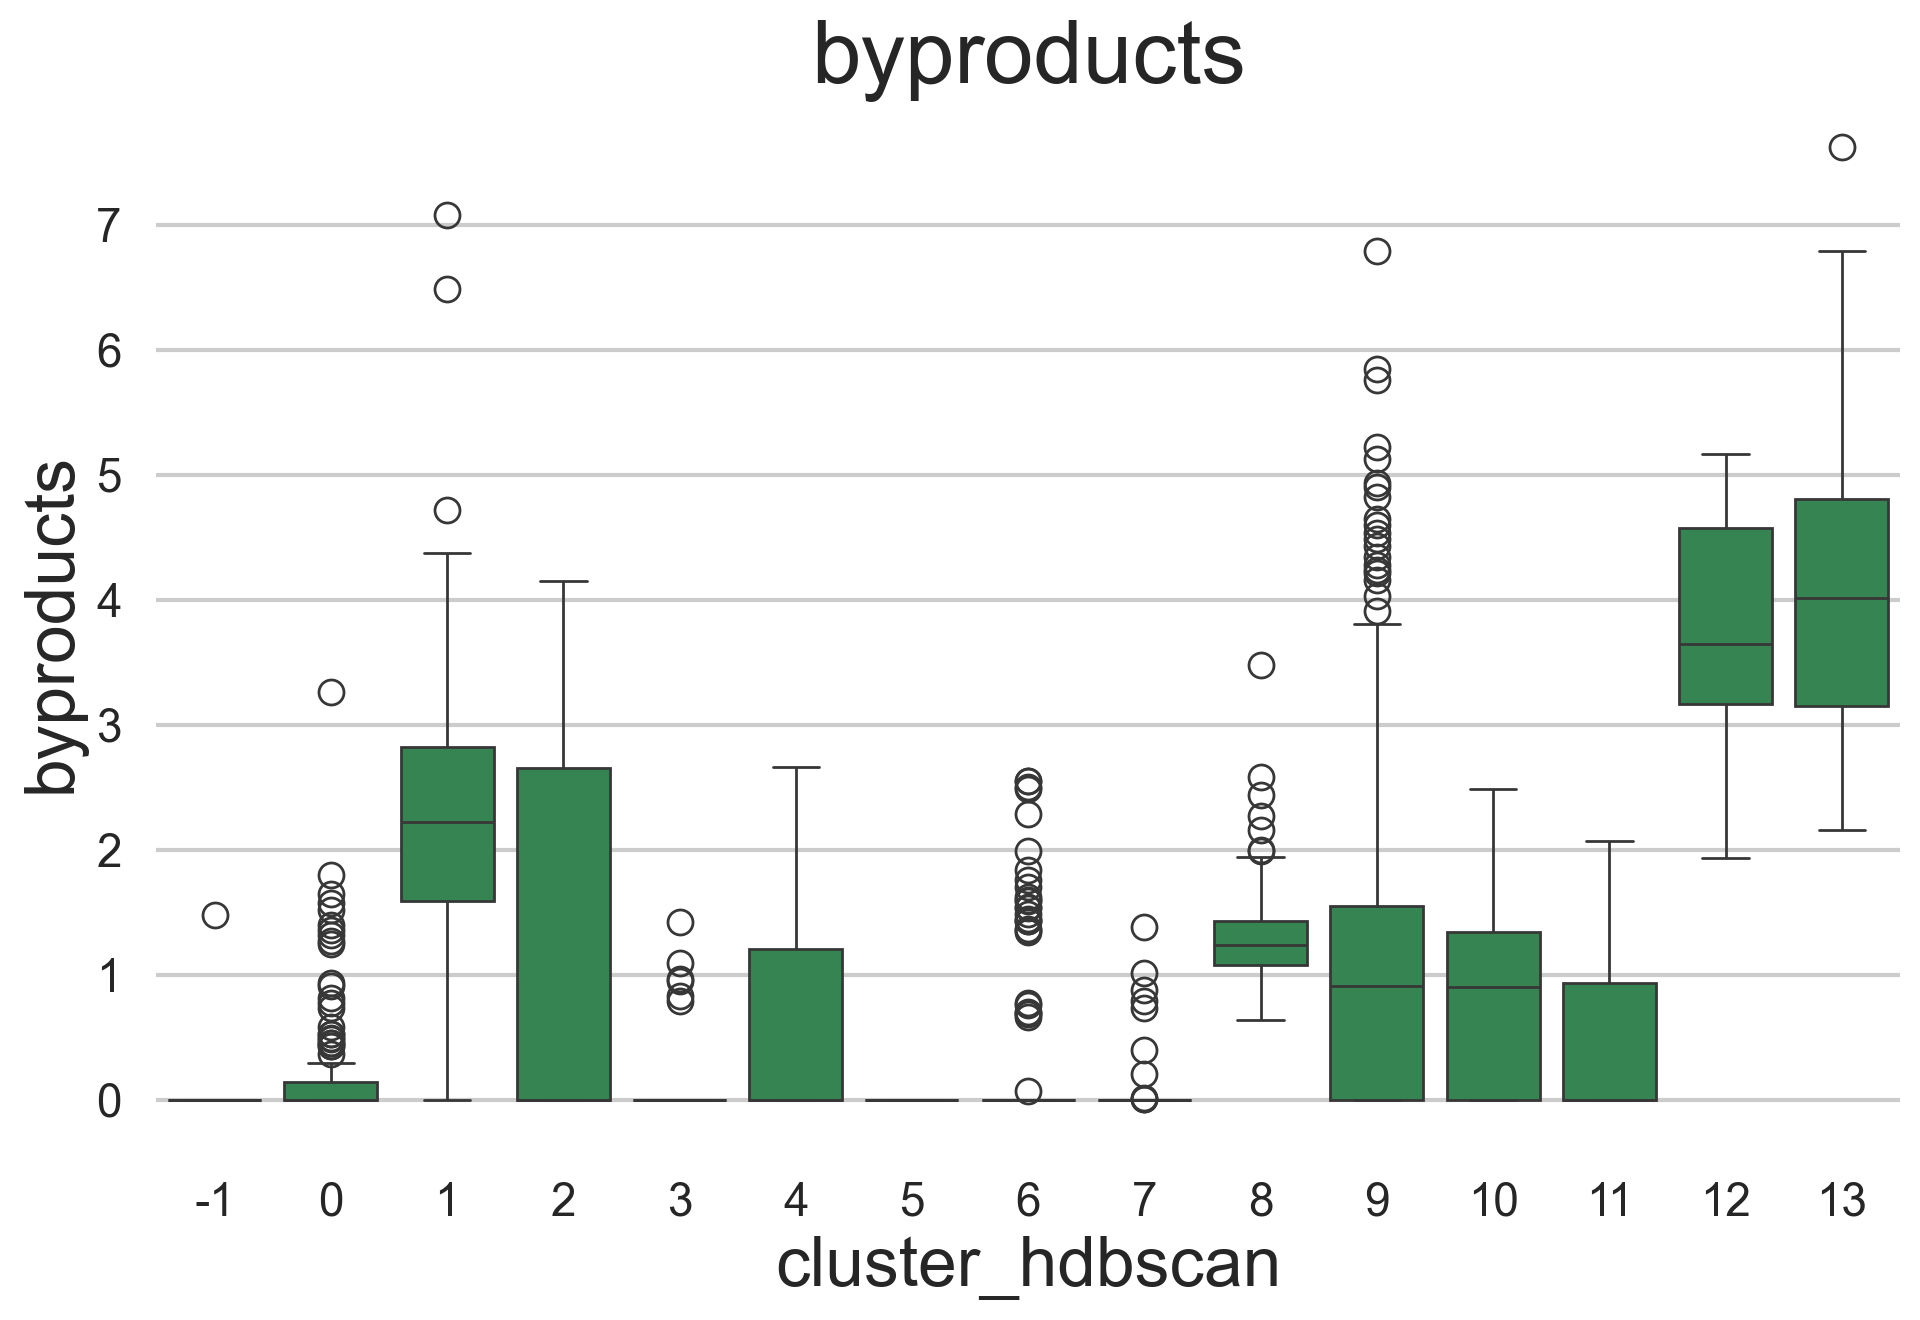

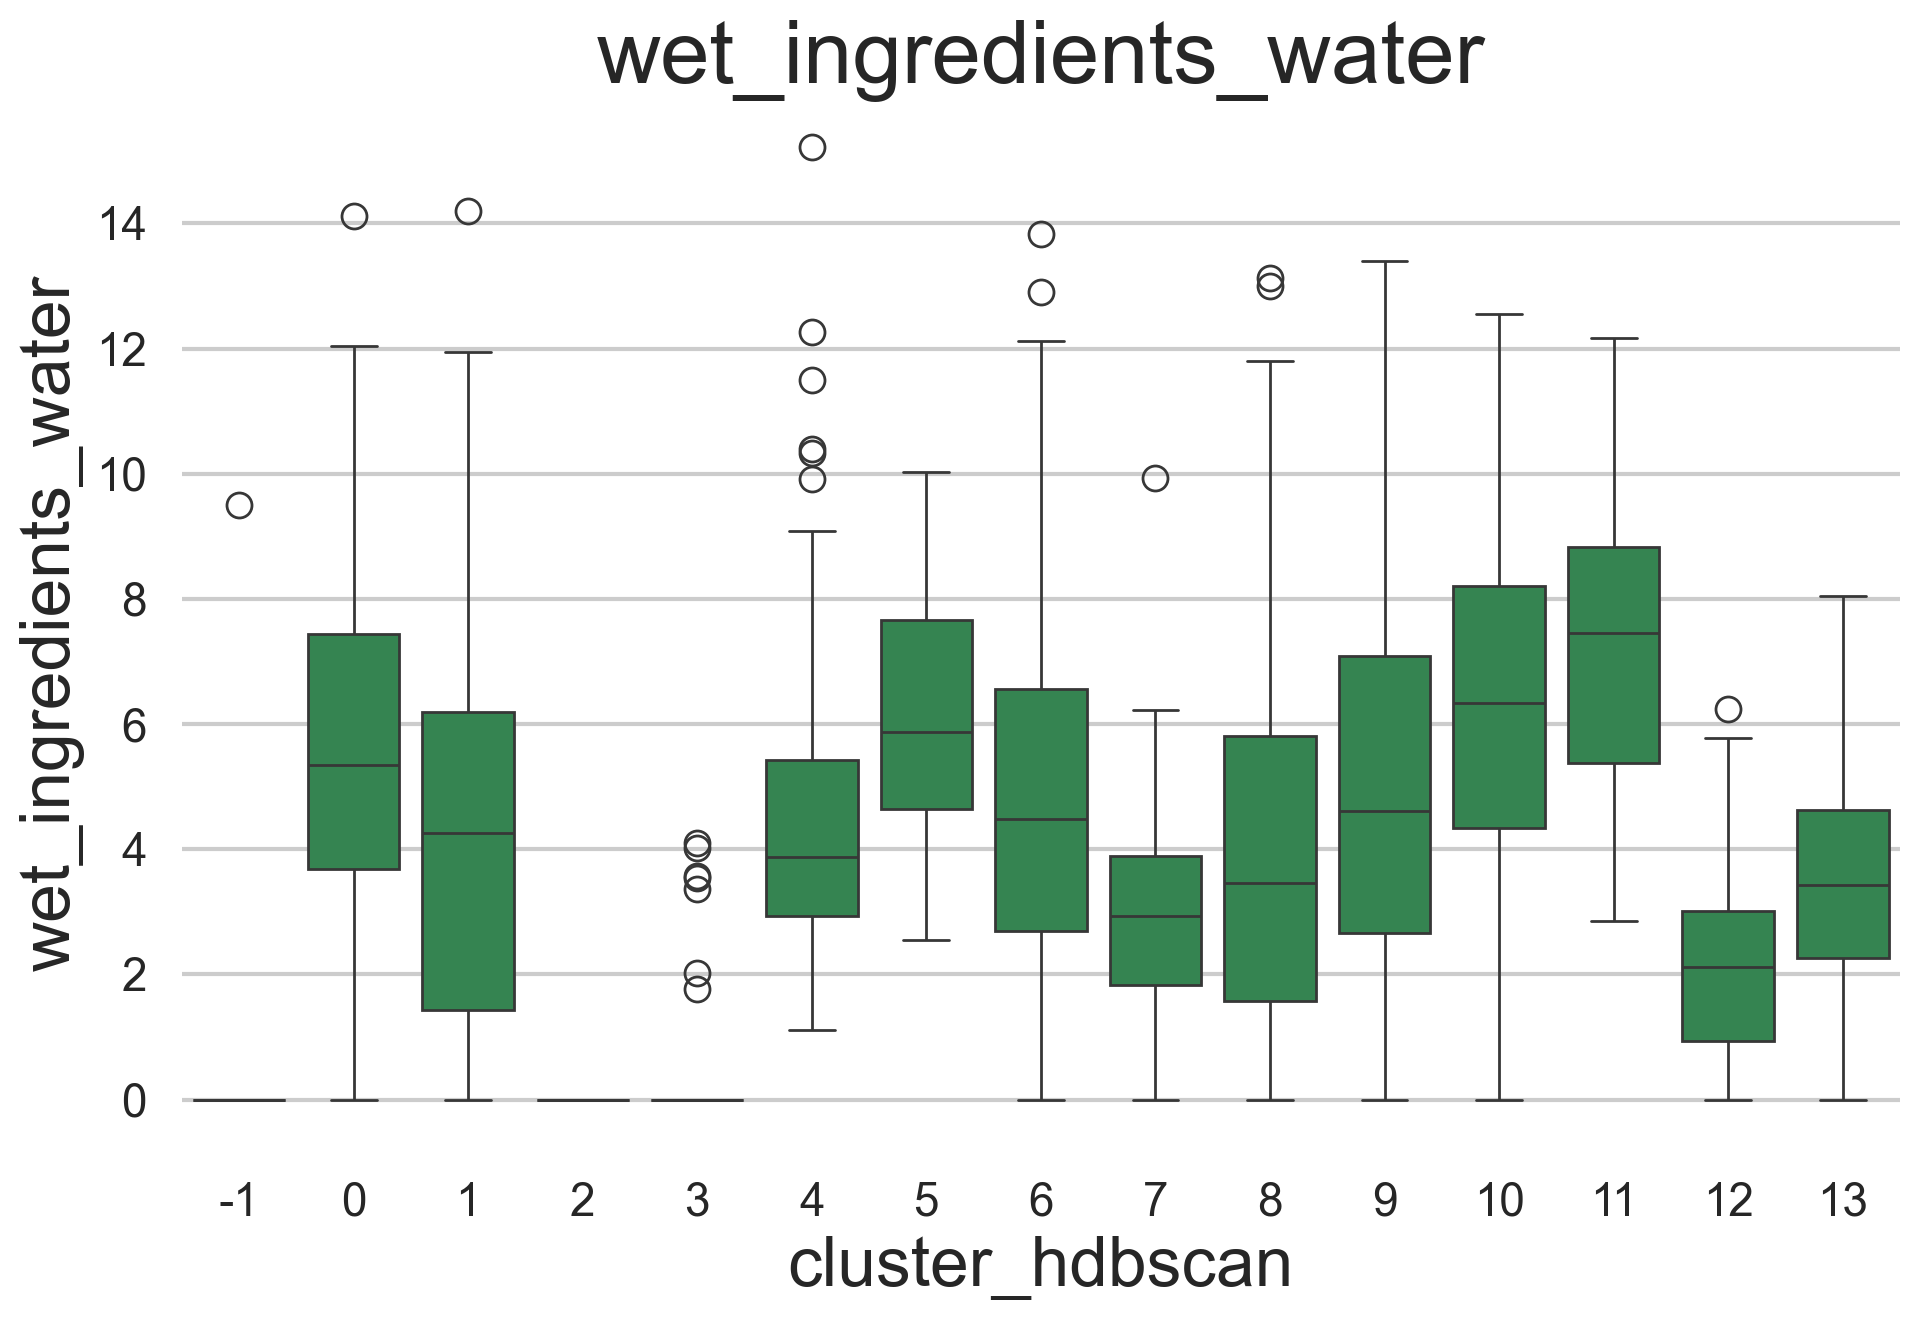

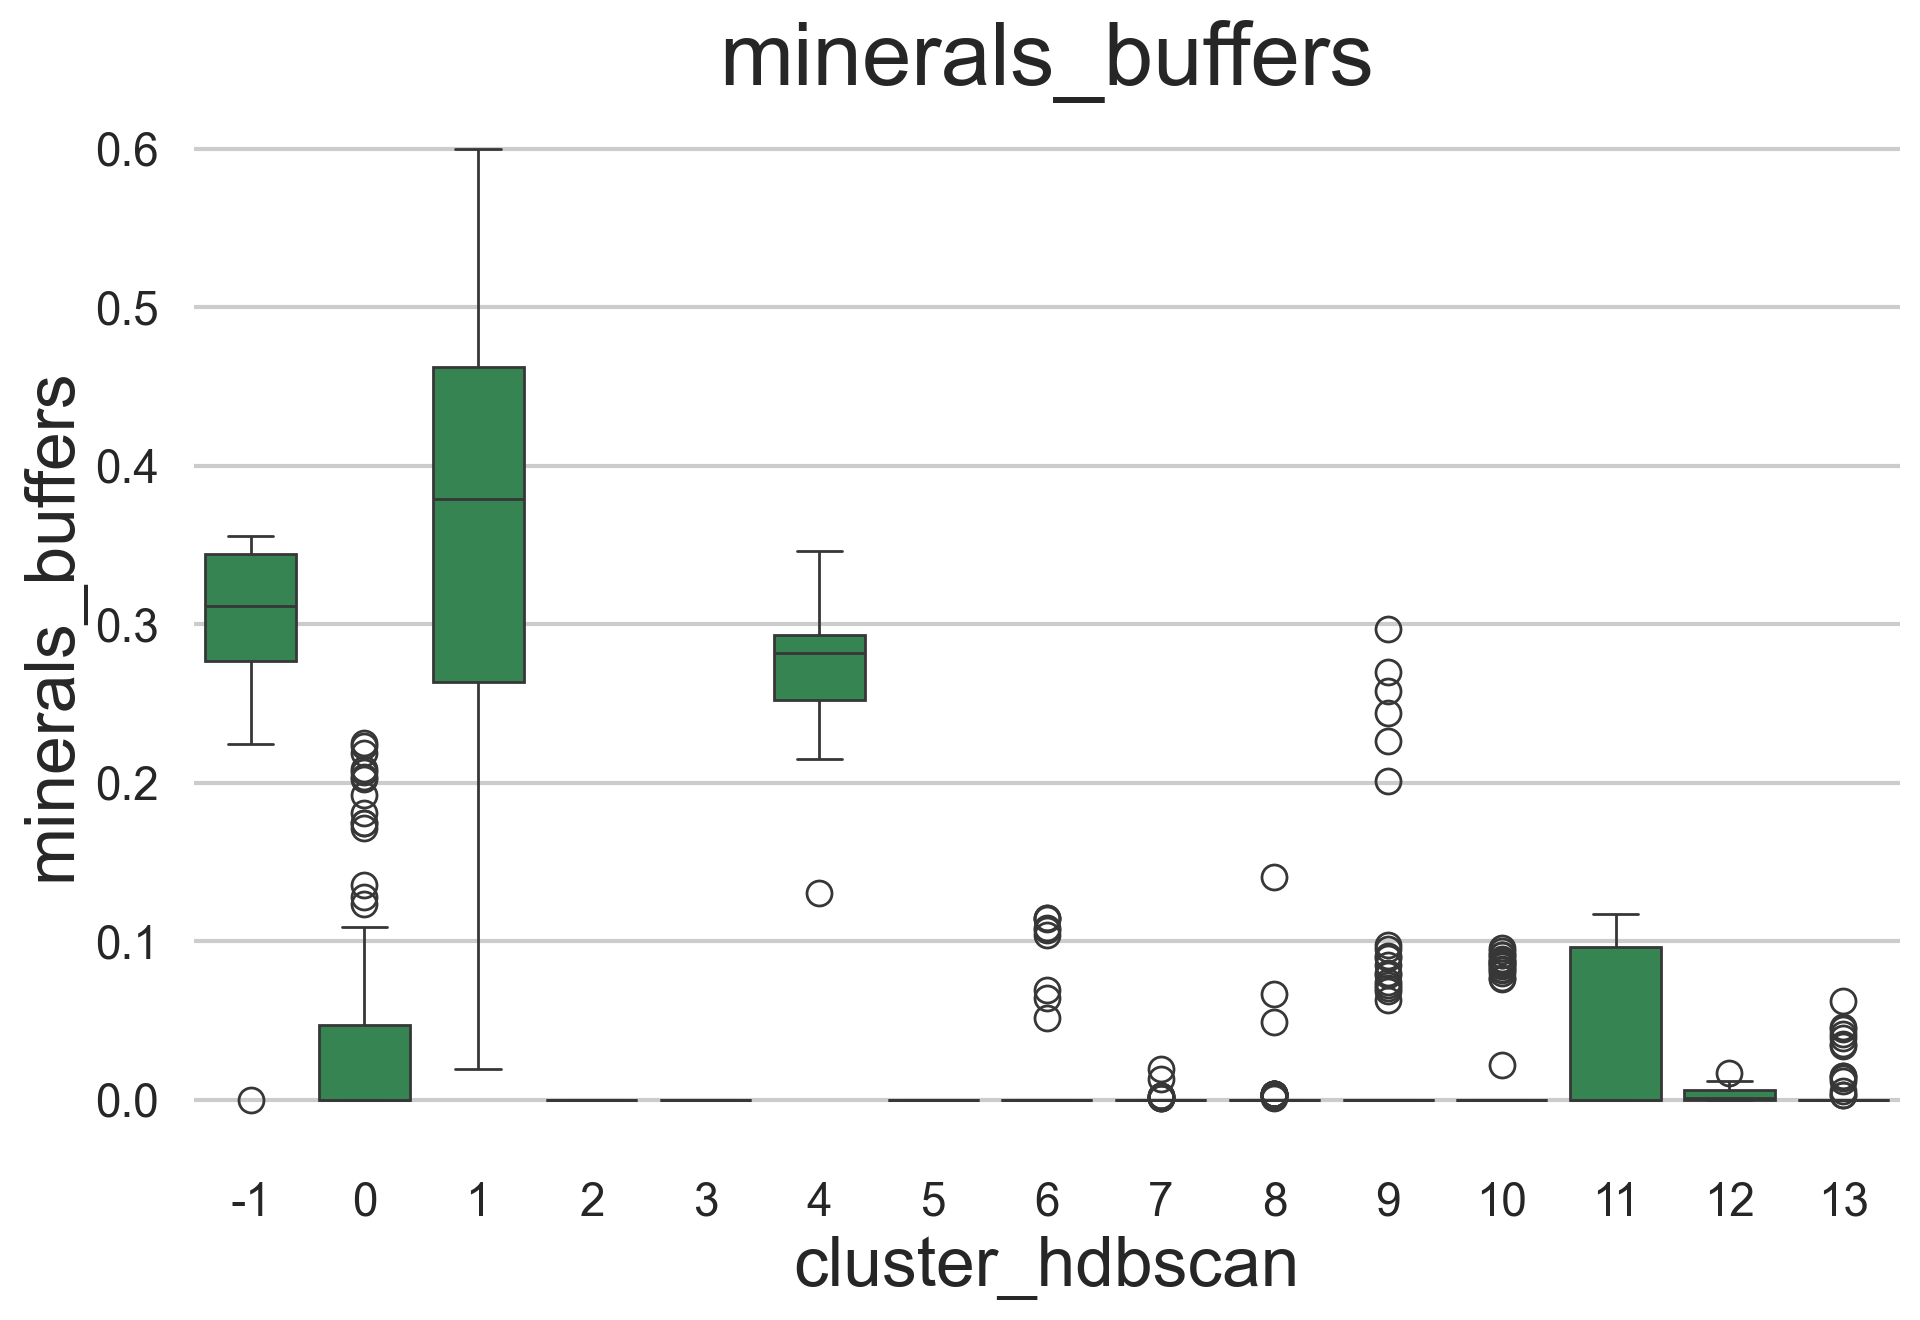

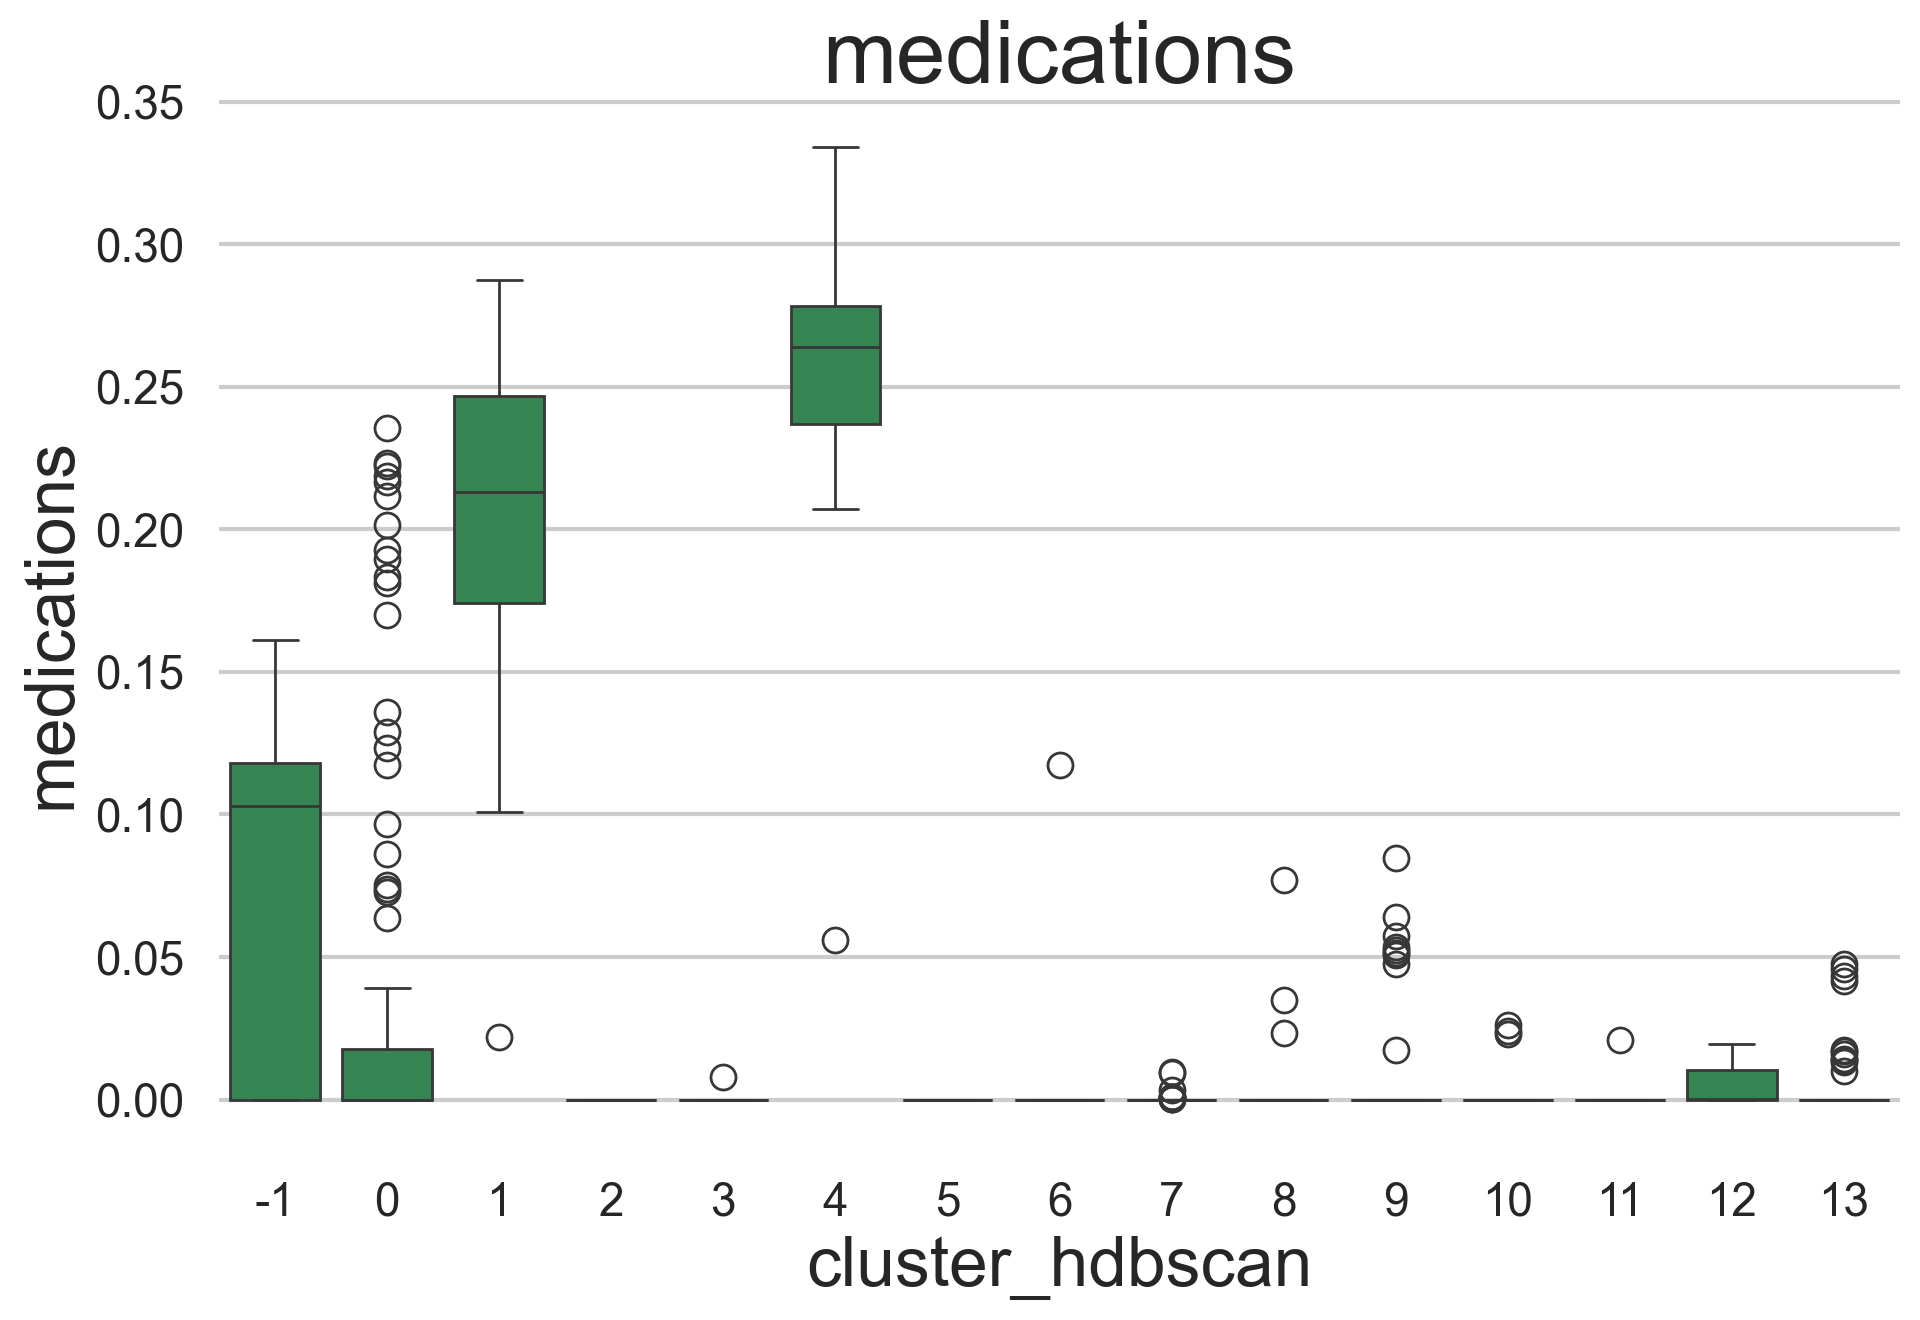

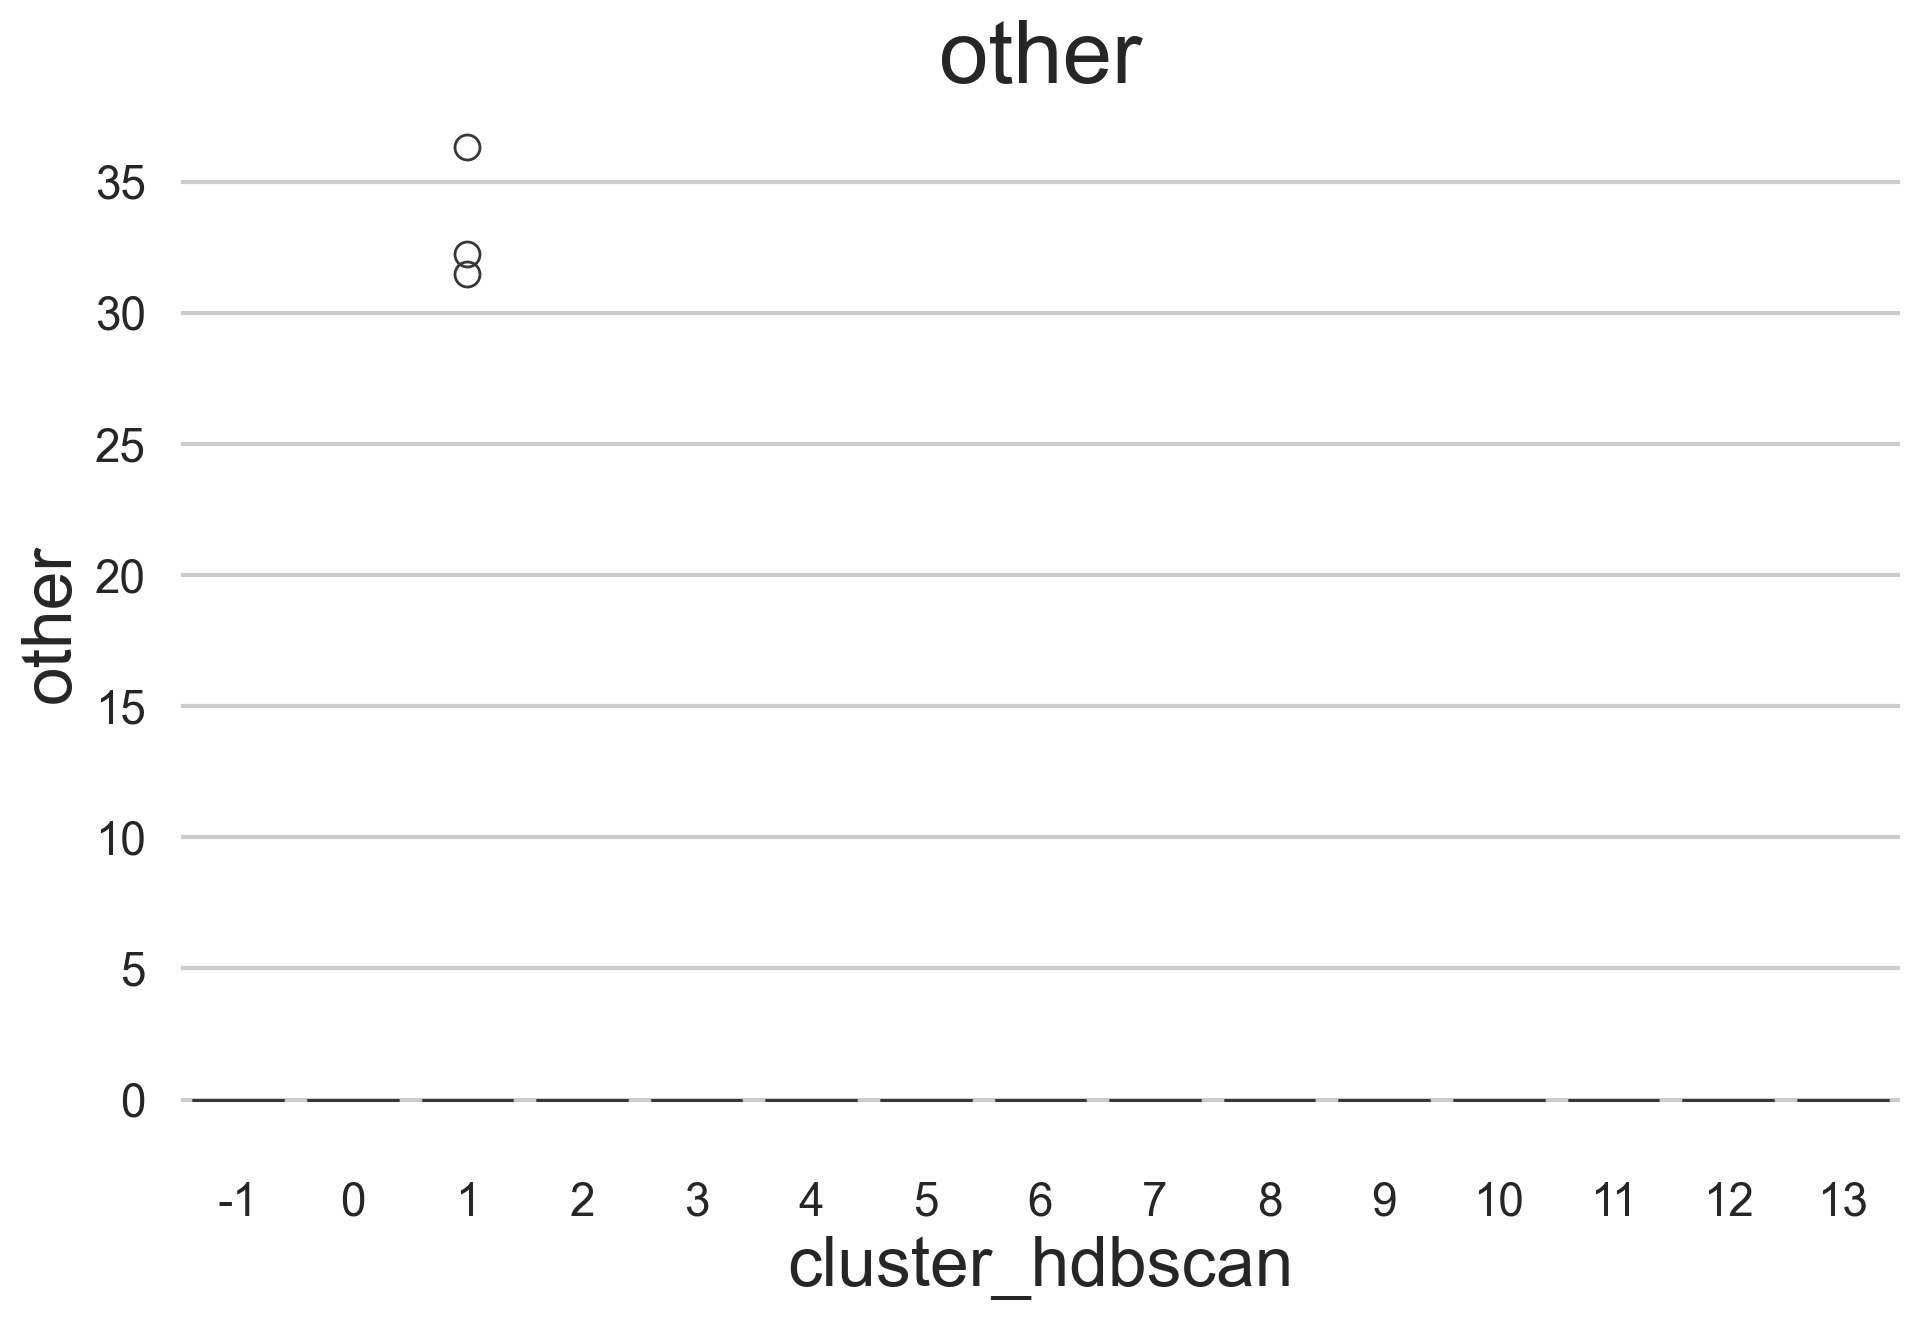

In [ ]:
for col in features:
    sns.boxplot(data=div_vectors, x="cluster_hdbscan", y=col)
    plt.title(col)
    plt.show()


In [15]:
from scipy.stats import kruskal

for col in features:
    groups = [div_vectors[div_vectors.cluster_hdbscan==c][col] 
              for c in div_vectors.cluster_hdbscan.unique()]
    stat, p = kruskal(*groups)
    print(col, p)


forage_bulk 1.1230080003875965e-98
energy_source 1.2524484190286114e-155
protein_source 3.2190583012861817e-153
fat_oils 1.8663683854534966e-215
yeast_products 3.351527618829434e-262
feed_additives_probiotics 5.874079622032852e-46
compound_feed_calf_replacements 9.313110910246541e-259
premix_feed 3.9405428928082053e-219
byproducts 6.574204506210063e-180
wet_ingredients_water 6.388181458823744e-61
minerals_buffers 1.3947231079785279e-191
medications 2.202641303177336e-224
other 8.839565330069821e-07


In [17]:
import pandas as pd

corr = milking_feeding[features + ['weekly_milking_per_cow']].corr()['weekly_milking_per_cow']
corr.sort_values(ascending=False)


weekly_milking_per_cow             1.000000
yeast_products                     0.115991
protein_source                     0.094753
forage_bulk                        0.028143
byproducts                         0.022413
fat_oils                           0.000593
compound_feed_calf_replacements   -0.013831
wet_ingredients_water             -0.055082
other                             -0.065417
energy_source                     -0.068405
medications                       -0.073162
premix_feed                       -0.086121
feed_additives_probiotics         -0.131467
minerals_buffers                  -0.167105
Name: weekly_milking_per_cow, dtype: float64

In [18]:
milking_feeding.groupby("cluster_hdbscan")['weekly_milking_per_cow'].mean()


cluster_hdbscan
0     32.869892
1     32.598551
3     23.728571
4     39.347826
5     36.000000
6     35.117352
7     38.921569
8     38.676898
9     37.094631
10    35.405660
11    37.025000
12    37.257143
13    36.309259
Name: weekly_milking_per_cow, dtype: float64

            Source  ddof1  ddof2          F         p-unc       np2
0  cluster_hdbscan     12   1071  32.115256  1.657016e-63  0.264617


,A,B,mean(A),mean(B),diff,se,T,df,pval,hedges
0,0,1,32.869892,32.598551,0.271342,1.256391,0.215969,78.210399,1.000000e+00,0.038605
1,0,3,32.869892,23.728571,9.141321,3.992255,2.289764,6.083408,5.787090e-01,2.242853
2,0,4,32.869892,39.347826,-6.477934,0.478078,-13.549941,117.429393,2.498002e-14,-2.191093
3,0,5,32.869892,36.000000,-3.130108,NaN,NaN,NaN,NaN,[-0.9801396006356875]
4,0,6,32.869892,35.117352,-2.247459,0.420858,-5.340188,206.950692,1.839612e-05,-0.612114
...,...,...,...,...,...,...,...,...,...,...
73,10,12,35.405660,37.257143,-1.851482,0.489653,-3.781214,84.736660,1.660001e-02,-0.735998
74,10,13,35.405660,36.309259,-0.903599,0.568421,-1.589666,104.997869,9.292771e-01,-0.305103
75,11,12,37.025000,37.257143,-0.232143,0.716078,-0.324187,4.208059,9.999998e-01,-0.137671
76,11,13,37.025000,36.309259,0.715741,0.772081,0.927028,5.658523,9.960160e-01,0.242696


In [20]:
from scipy.stats import f_oneway

groups = [milking_feeding[milking_feeding['cluster_dbscan']==i]['protein'].dropna() for i in milking_feeding['cluster_dbscan'].unique()]
display(f_oneway(*groups), pg.pairwise_gameshowell(dv='protein', between='cluster_dbscan', data=milking_feeding))

display(
    pg.pairwise_gameshowell(dv='additive', between='cluster_dbscan', data=milking_feeding),
    pg.pairwise_gameshowell(dv='byproduct', between='cluster_dbscan', data=milking_feeding),
    pg.pairwise_gameshowell(dv='energy', between='cluster_dbscan', data=milking_feeding),
    pg.pairwise_gameshowell(dv='fat', between='cluster_dbscan', data=milking_feeding),
    pg.pairwise_gameshowell(dv='forage', between='cluster_dbscan', data=milking_feeding),
    pg.pairwise_gameshowell(dv='mineral_vit', between='cluster_dbscan', data=milking_feeding),
    pg.pairwise_gameshowell(dv='premix', between='cluster_dbscan', data=milking_feeding),
    pg.pairwise_gameshowell(dv='premix_blend', between='cluster_dbscan', data=milking_feeding),
    pg.pairwise_gameshowell(dv='water', between='cluster_dbscan', data=milking_feeding)
)

KeyError: 'protein'

In [ ]:
union

,date,region,prod_farm_name,farm_name,cows_total,milk_cows,milk_cows_d0,milk_cows_d1,milk_cows_d2,milk_cows_d3,weekly_milking_per_cow,gross_milk_yield,cow_retired_farm,cow_retired_low_prod,cow_retired_hooves,cow_retired_inj_joint,cow_retired_mastit,cow_retired_jkt,bull_num,farm_type,ls_capacity,ls_occupancy,forage_cow,milk_cow,dry_cow,milk_marketab_prc,forcow_milk_yeild,forcow_milk_yeild_stand,milk_fat,milk_protein,somatic_cells,bac_contam,cow_retired_herd,cow_lame,cow_mastits,calves,cow_metrit,ph_urine_avr,diff,year_month
0,2020-01-01,Рязань,Ока Молоко Север,ЖК Авангард,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ЖК,1327.0,93.669932,1243.0,1073.0,170.0,96.0,NaN,NaN,NaN,NaN,170.0,56.0,34.0,36.0,48,NaN,NaN,NaN,NaN,2020-01
1,2020-01-01,Калуга,Калужская Нива Восток,ЖК Аристово,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ЖК,2800.0,112.500000,3150.0,2933.0,217.0,98.0,NaN,NaN,NaN,NaN,100.0,50.0,52.0,75.0,99,NaN,NaN,NaN,NaN,2020-01
2,2020-01-01,Воронеж,ЭНА Восток,ЖК Бобров,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ЖК,2800.0,95.535714,2675.0,2329.0,346.0,94.0,NaN,NaN,NaN,NaN,92.0,41.0,52.0,90.0,57,NaN,NaN,NaN,NaN,2020-01
3,2020-01-01,Воронеж,ЭНА Восток,ЖК Бобров-2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ЖК,2800.0,101.678571,2847.0,2378.0,469.0,96.0,NaN,NaN,NaN,NaN,90.0,29.0,30.0,44.0,27,NaN,NaN,NaN,NaN,2020-01
4,2020-01-01,Калуга,Калужская Нива Восток,ЖК Богданино,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ЖК,2800.0,105.392857,2951.0,2396.0,557.0,100.0,NaN,NaN,NaN,NaN,104.0,50.0,41.0,146.0,42,NaN,NaN,NaN,NaN,2020-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4542,2025-07-01,Сибирь,Сибирская Нива Маслянино,РМ Пеньково,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,164.0,РМ,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2025-07
4543,2025-07-01,Калуга,Калужская Нива Юг,РМ Поляна,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,РМ,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2025-07
4544,2025-07-01,Калуга,Калужская Нива Запад,РМ Романово Нов.,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,РМ,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2025-07
4545,2025-07-01,Калуга,Калужская Нива Юг,РМ Торопово,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,РМ,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2025-07


F-statistic: nan
p-value: nan


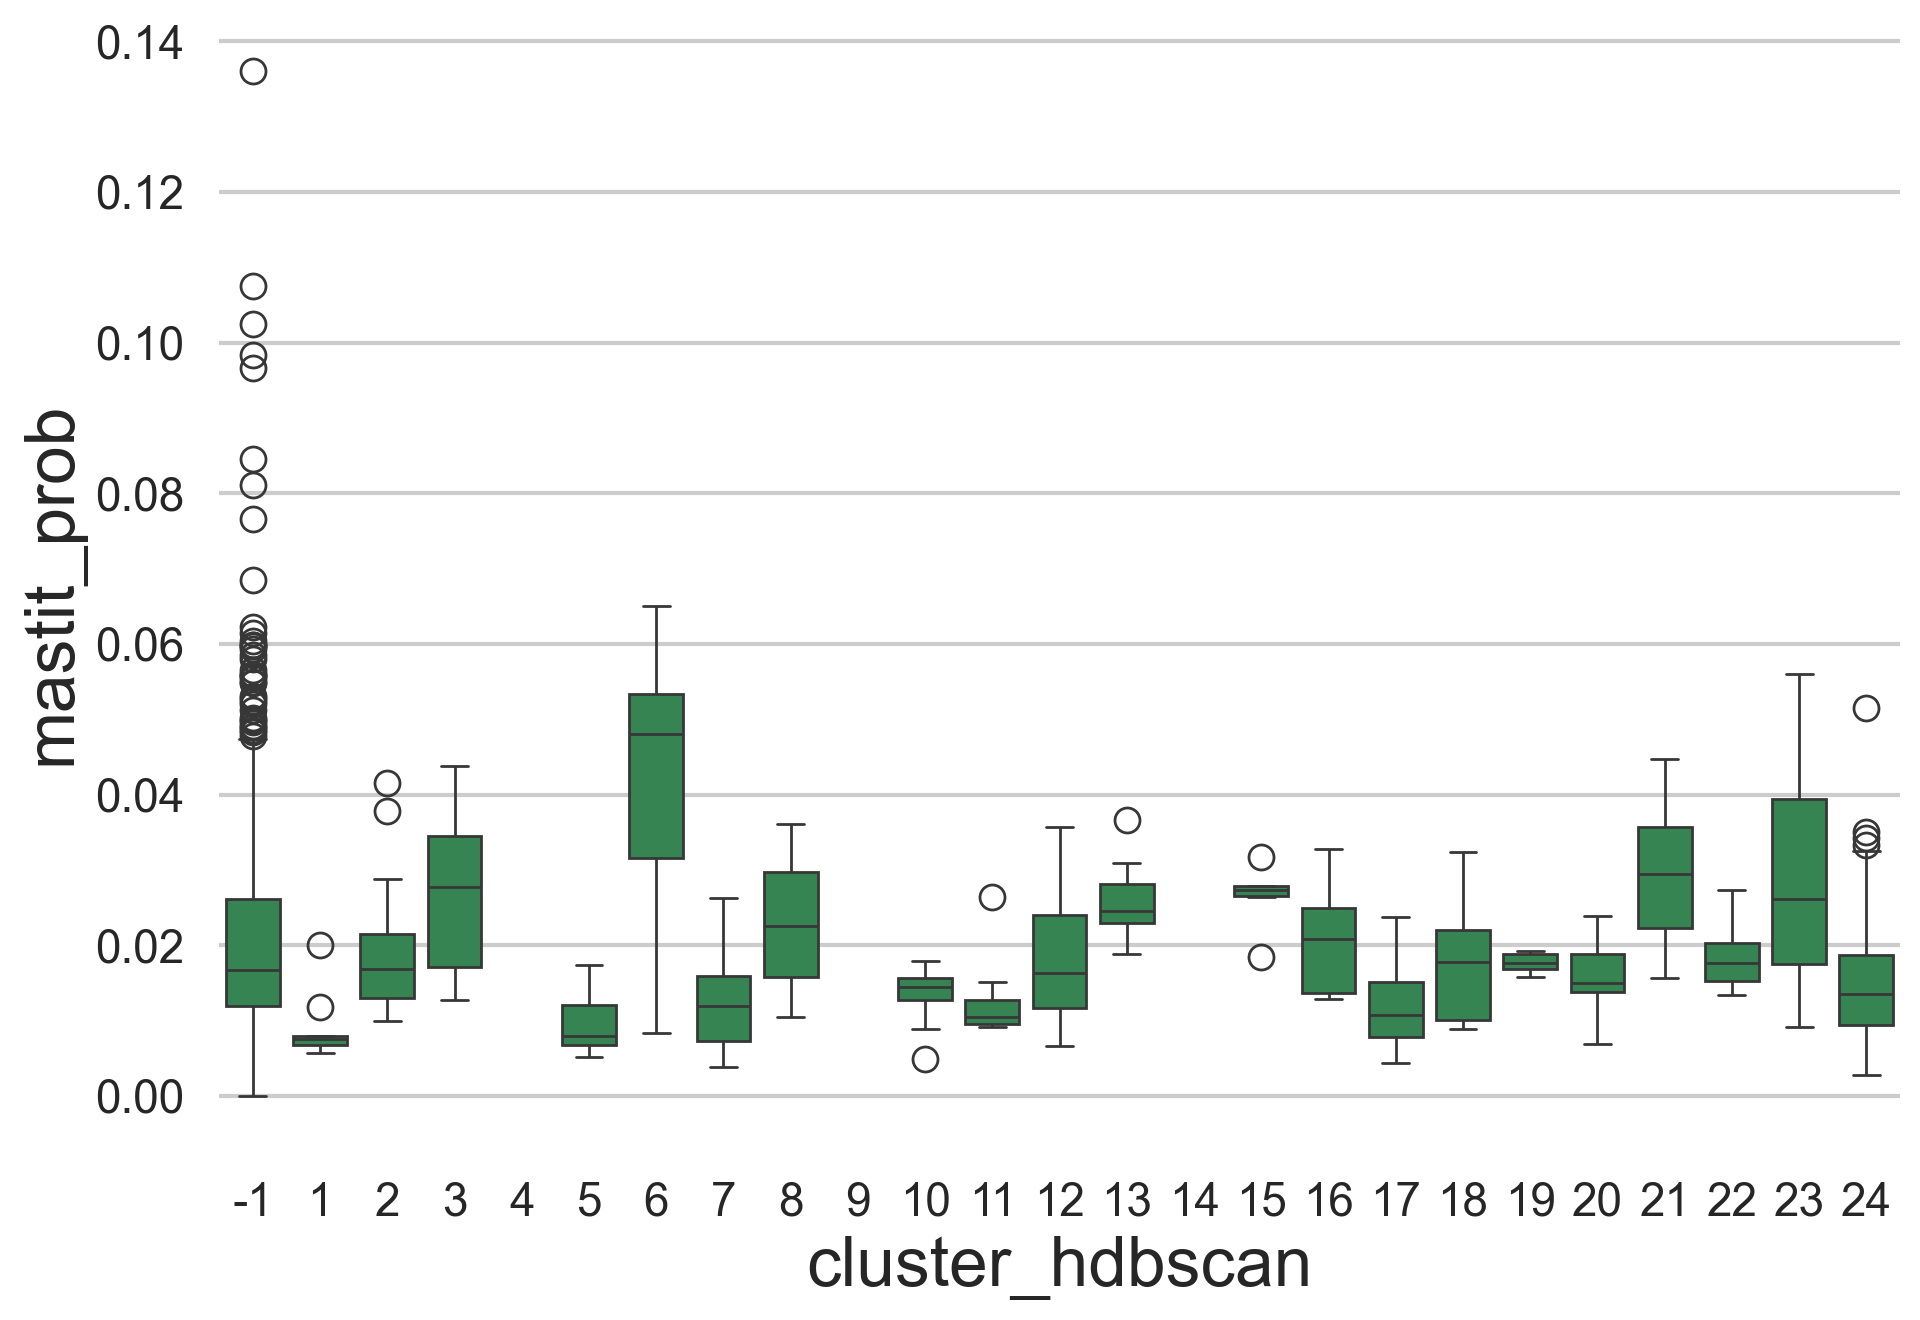

In [67]:
herd_metrics["year_month"] = herd_metrics["date"].dt.to_period("M").astype(str)
mont = pd.read_csv('monthly_vectors.csv', index_col=0)

df = pd.merge(mont.rename(columns={'FarmName': 'farm_name'}), herd_metrics, on=['year_month', 'farm_name'], how='inner')
df['cow_mastits'] = df["cow_mastits"].replace({"83-": "83"})
df['cow_mastits'] = pd.to_numeric(df['cow_mastits'], errors='coerce')
df["mastit_prob"] = df["cow_mastits"] / (df["ls_capacity"] * df["ls_occupancy"] / 100)
sns.boxplot(df, x="cluster_hdbscan", y="mastit_prob")


groups = [
    g["mastit_prob"].dropna().values
    for _, g in df.groupby("cluster_hdbscan")
]

f_stat, p_val = f_oneway(*groups)

print("F-statistic:", f_stat)
print("p-value:", p_val)

In [69]:
mont.groupby("cluster_hdbscan")[features].mean()

,forage_bulk,energy_source,protein_source,fat_oils,yeast_products,feed_additives_probiotics,compound_feed_calf_replacements,premix_feed,byproducts,wet_ingredients_water,minerals_buffers,medications,other
cluster_hdbscan,,,,,,,,,,,,,
-1,24.741070,3.394776,2.355746,0.092242,0.027641,0.056934,2.391875,0.178715,3.925836,4.543996,0.101576,0.078529,0.097854
0,32.585064,0.210700,3.214702,0.553060,0.000000,0.000000,0.000000,0.000000,0.000000,5.978678,0.226204,0.063631,0.000000
1,36.212544,3.876319,2.541799,0.232911,0.000000,0.373763,0.000000,0.280462,1.278753,7.113984,0.427899,0.169857,0.000000
2,31.715980,0.919562,0.000000,0.000000,0.002187,0.000000,0.000000,0.000000,0.723433,6.746259,0.000000,0.076221,0.000000
3,32.968988,2.051840,4.422060,0.000000,0.000000,0.010566,0.000000,0.100439,1.776983,0.000000,0.100349,0.000000,0.000000
4,20.687635,0.057950,1.466123,0.000000,0.000000,0.000000,0.000000,0.198901,0.748058,0.000000,0.000000,0.000000,0.000000
5,33.992680,0.919650,1.016248,0.000000,0.000000,0.012123,4.632286,0.294762,2.648651,4.174508,0.303898,0.325945,0.000000
6,33.713059,1.646665,5.407204,0.000000,0.000000,0.016732,2.853006,0.153644,0.375009,0.000000,0.103075,0.000000,0.000000
7,31.289415,0.528005,0.954756,0.000000,0.000000,0.056895,0.285049,0.249197,0.176783,3.370300,0.212604,0.238470,0.000000


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

for col in features:
    sns.boxplot(data=div_vectors, x="cluster_hdbscan", y=col)
    plt.title(col)
    plt.show()


In [ ]:
milking_feeding

,date,region,prod_farm_name,farm_name,cows_total,milk_cows,milk_cows_d0,milk_cows_d1,milk_cows_d2,milk_cows_d3,weekly_milking_per_cow,gross_milk_yield,cow_retired_farm,cow_retired_low_prod,cow_retired_hooves,cow_retired_inj_joint,cow_retired_mastit,cow_retired_jkt,bull_num,farm_type,ls_capacity,ls_occupancy,forage_cow,milk_cow,dry_cow,milk_marketab_prc,forcow_milk_yeild,forcow_milk_yeild_stand,milk_fat,milk_protein,somatic_cells,bac_contam,cow_retired_herd,cow_lame,cow_mastits,calves,cow_metrit,ph_urine_avr,diff,year_month,buffers_ph,byproducts,compound_feed_calf_replacements,energy_source,fat_oils,feed_additives_probiotics,forage_bulk,metabolic_support,minerals_vitamins,preventive_supplements,protein_source,wet_ingredients_water,dist_to_center_euclid,dist_to_center_manhattan,pca1,pca2,cluster_kmeans,cluster_hdbscan,cluster_dbscan
0,2022-01-01,Воронеж,ЭНА Левый берег,ЖК Добрино,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ЖК,2800.0,104.964286,2939.0,2748.0,191.0,94.0,NaN,NaN,NaN,NaN,85.0,12.0,51.0,59.0,31,NaN,NaN,NaN,NaN,2022-01,0.008010,0.000000,2.405793,4.311505,0.099607,0.0,23.563974,0.0,0.074354,0.066918,4.034868,3.869570,16.778645,43.423790,-6.971978,-9.151967,1,17,0
1,2022-01-01,Воронеж,ЭНА Север,ЖК Коршево,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ЖК,2800.0,101.428571,2840.0,2625.0,215.0,96.0,NaN,NaN,NaN,NaN,92.0,26.0,51.0,30.0,58,NaN,NaN,NaN,NaN,2022-01,0.000000,0.000000,2.851766,3.508720,0.120975,0.0,16.752086,0.0,0.000000,0.000000,3.744197,10.175491,16.535679,43.983846,3.783750,-13.759694,1,15,1
2,2022-02-01,Воронеж,ЭНА Левый берег,ЖК Бодеевка,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ЖК,2800.0,106.750000,2989.0,2717.0,272.0,98.0,NaN,NaN,NaN,NaN,117.0,2.0,32.0,60.0,17,NaN,NaN,NaN,NaN,2022-02,0.029581,0.000000,2.492408,4.463265,0.087247,0.0,20.743027,0.0,0.146970,0.113568,4.151203,6.107249,17.432947,46.364177,-7.741997,-8.973654,6,17,0
3,2022-02-01,Воронеж,ЭНА Левый берег,ЖК Добрино,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ЖК,2800.0,105.857143,2964.0,2723.0,241.0,99.0,NaN,NaN,NaN,NaN,NaN,NaN,34.0,37.0,41,NaN,NaN,NaN,NaN,2022-02,0.037672,0.000000,2.413085,4.379899,0.107118,0.0,24.196274,0.0,0.151681,0.084396,4.045891,4.298722,17.456516,46.052866,-7.836637,-8.980297,6,17,0
4,2022-02-01,Воронеж,ЭНА Север,ЖК Коршево,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ЖК,2800.0,101.714286,2848.0,2636.0,212.0,97.0,NaN,NaN,NaN,NaN,85.0,5.3,45.0,33.0,38,NaN,NaN,NaN,NaN,2022-02,0.000000,0.000000,2.832872,3.296320,0.146397,0.0,19.360977,0.0,0.000000,0.000000,3.627228,7.898601,16.565426,43.968302,3.707657,-13.755357,1,15,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1387,2025-07-01,Рязань,Ока Молоко Шацк,ЖК Шацк,6288.0,5569.0,214.0,4873.0,482.0,0.0,43.5,237693.0,269.0,154.0,13.0,12.0,22.0,17.0,32.0,ЖК,6300.0,100.000000,6288.0,5569.0,719.0,98.0,35.05,37.4,3.9,3.5,65.0,16.0,269.0,51.0,146,955.0,164.0,6.2,12.0,2025-07,0.000000,0.000000,0.000000,9.206771,0.000000,0.0,31.120447,0.0,0.000000,0.000000,3.300254,11.355072,14.946433,43.242989,-2.906104,-9.050181,1,4,-1
1388,2025-07-01,Воронеж,ЭНА Правый берег,ЖК Щучье,1260.0,1093.0,78.0,939.0,0.0,76.0,32.1,33946.0,39.0,6.0,0.0,0.0,2.0,14.0,53.0,ЖК,1200.0,105.000000,1260.0,1093.0,167.0,97.0,26.97,27.7,3.6,3.4,108.0,2.3,39.0,29.0,13,211.0,37.0,6.2,0.0,2025-07,0.000000,36.640886,4.551251,5.731829,0.000000,0.0,29.355276,0.0,0.000000,0.000000,4.209796,2.752411,12.324582,35.014396,11.221033,3.204195,4,34,4
1389,2025-07-01,МоПеТю,Междуречье,МТФ Гилево,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,МТФ,400.0,99.000000,396.0,384.0,12.0,98.0,26.03,29.6,4.4,3.5,150.0,10.0,39.0,44.0,10,29.0,7.0,NaN,NaN,2025-07,0.146574,3.278006,0.000000,9.129858,0.000000,0.0,29.725194,0.0,0.296125,0.150417,3.141289,0.000000,21.909499,5

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

df = mont.copy()[{
    # Основной корм/кормовая база (фураж) — для обеспечения клетчатки, объёма рациона
    "forage_bulk": [
        "силос", "сенаж", "сено", "люцерн", "солома", "зеленая масса", "зел масса",
        "сило", "сорго", "солома пшеницы", "солома ячменя", "сенокос", "сенок",
        "тюк", "тюкован", "травосмесь", "сенокуб", "сеносилос", "рожь", "трава",
        "солома", "солома", "soloma", "cилос"
    ],

    # Энергетические компоненты — зерно, крахмал, меласса, глицерин и пр.
    "energy_source": [
        "кукуруза", "пшениц", "ячмень", "овёс", "зерно", "corn", "wheat", "barley",
        "oats", "grain", "мука кукурузная", "мука ячменная", "кукуруза молотая",
        "дерть", "плющенка", "крахмал", "солод", "патока", "патока свекловичная",
        "меласса", "глицерин", "глицерин (glycerin)", "концентрат углевод", "корнаж", "карнаж",
        "глюгтен", "глютен", "корн", "зерносмесь", "солод", "тритикале"
    ],

    # Быстрые метаболические источники/антикетозные средства (используются при риске кетоза)
    "metabolic_support": [
        "глицерин", "глицерин (glycerin)", "пропиленгликоль", "пропиленгликоль (жидкий)",
        "propylene glycol", "глицерин", "глицерин", "энергетик"
    ],

    # Протеиновые компоненты
    "protein_source": [
        "шрот", "жмых", "соев", "соевый", "соя", "люпин", "горох", "бобы", "белок",
        "подсолн", "подсолнечный шрот", "экспандат", "экспеллер", "шрот соевый", "шр"
    ],

    # Жиры/защищённые жиры
    "fat_oils": [
        "жир", "масло", "жир защищённый", "масло соевое", "жир растительный", "жир животный",
        "пальмовое масло", "РЖК", "protected fat"
    ],

    # Минералы и витамины (профилактика дефицитов, костно-минеральный обмен)
    "minerals_vitamins": [
        "мел", "соль", "витамин", "минерал", "кальций", "фосфат", "извест", "Ca", "P",
        "NaCl", "CaCO3", "минсмесь", "витамины", "минералы", "ди кальций фосфат",
        "морская соль", "кальцит"
    ],

    # Буферы / рН регуляторы — профилактика ацидоза ()
    "buffers_ph": [
        "сода", "сода корм", "ниспользуются в рационеатрий бикарбонат", "буфер", "bicarbonate"
    ],

    # Электролиты / регидратация —  используются для профилактики и лечения дегидратации
    "electrolytes"
    "feed_additives_probiotics"
    "compound_feed_calf_replacements"
    "byproducts"
    "wet_ingredients_water"
    "medications"
    "preventive_supplements"
}]

# 1️⃣ Посмотрим средние значения признаков по кластерам
cluster_means = df.groupby('cluster_dbscan').mean()
print(cluster_means)

# 2️⃣ Построим тепловую карту средних значений
plt.figure(figsize=(12, 8))
sns.heatmap(cluster_means, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Средние значения признаков по кластерам")
plt.show()

# 3️⃣ Построим boxplot для каждого признака по кластерам
features = ['energy', 'fat', 'forage', 'protein', 'water', 'byproduct', 'premix_blend']

for feature in features:
    plt.figure(figsize=(10, 5))
    sns.boxplot(x='cluster_dbscan', y=feature, data=df)
    plt.title(f"Распределение {feature} по кластерам")
    plt.show()

# 4️⃣ Проверка связи с маститом (если есть колонка 'mastitis', 1 или 0)
if 'mastitis' in df.columns:
    plt.figure(figsize=(12, 6))
    sns.boxplot(x='cluster_dbscan', y='mastitis', data=df)
    plt.title("Мастит по кластерам")
    plt.show()

    # Корреляция признаков с маститом
    corr = df[features + ['mastitis']].corr()
    print(corr['mastitis'].sort_values(ascending=False))


KeyError: "['additive', 'byproduct', 'energy', 'fat', 'forage', 'mineral_vit', 'premix', 'premix_blend', 'protein', 'water'] not in index"

<Axes: xlabel='date', ylabel='cow_metrit'>

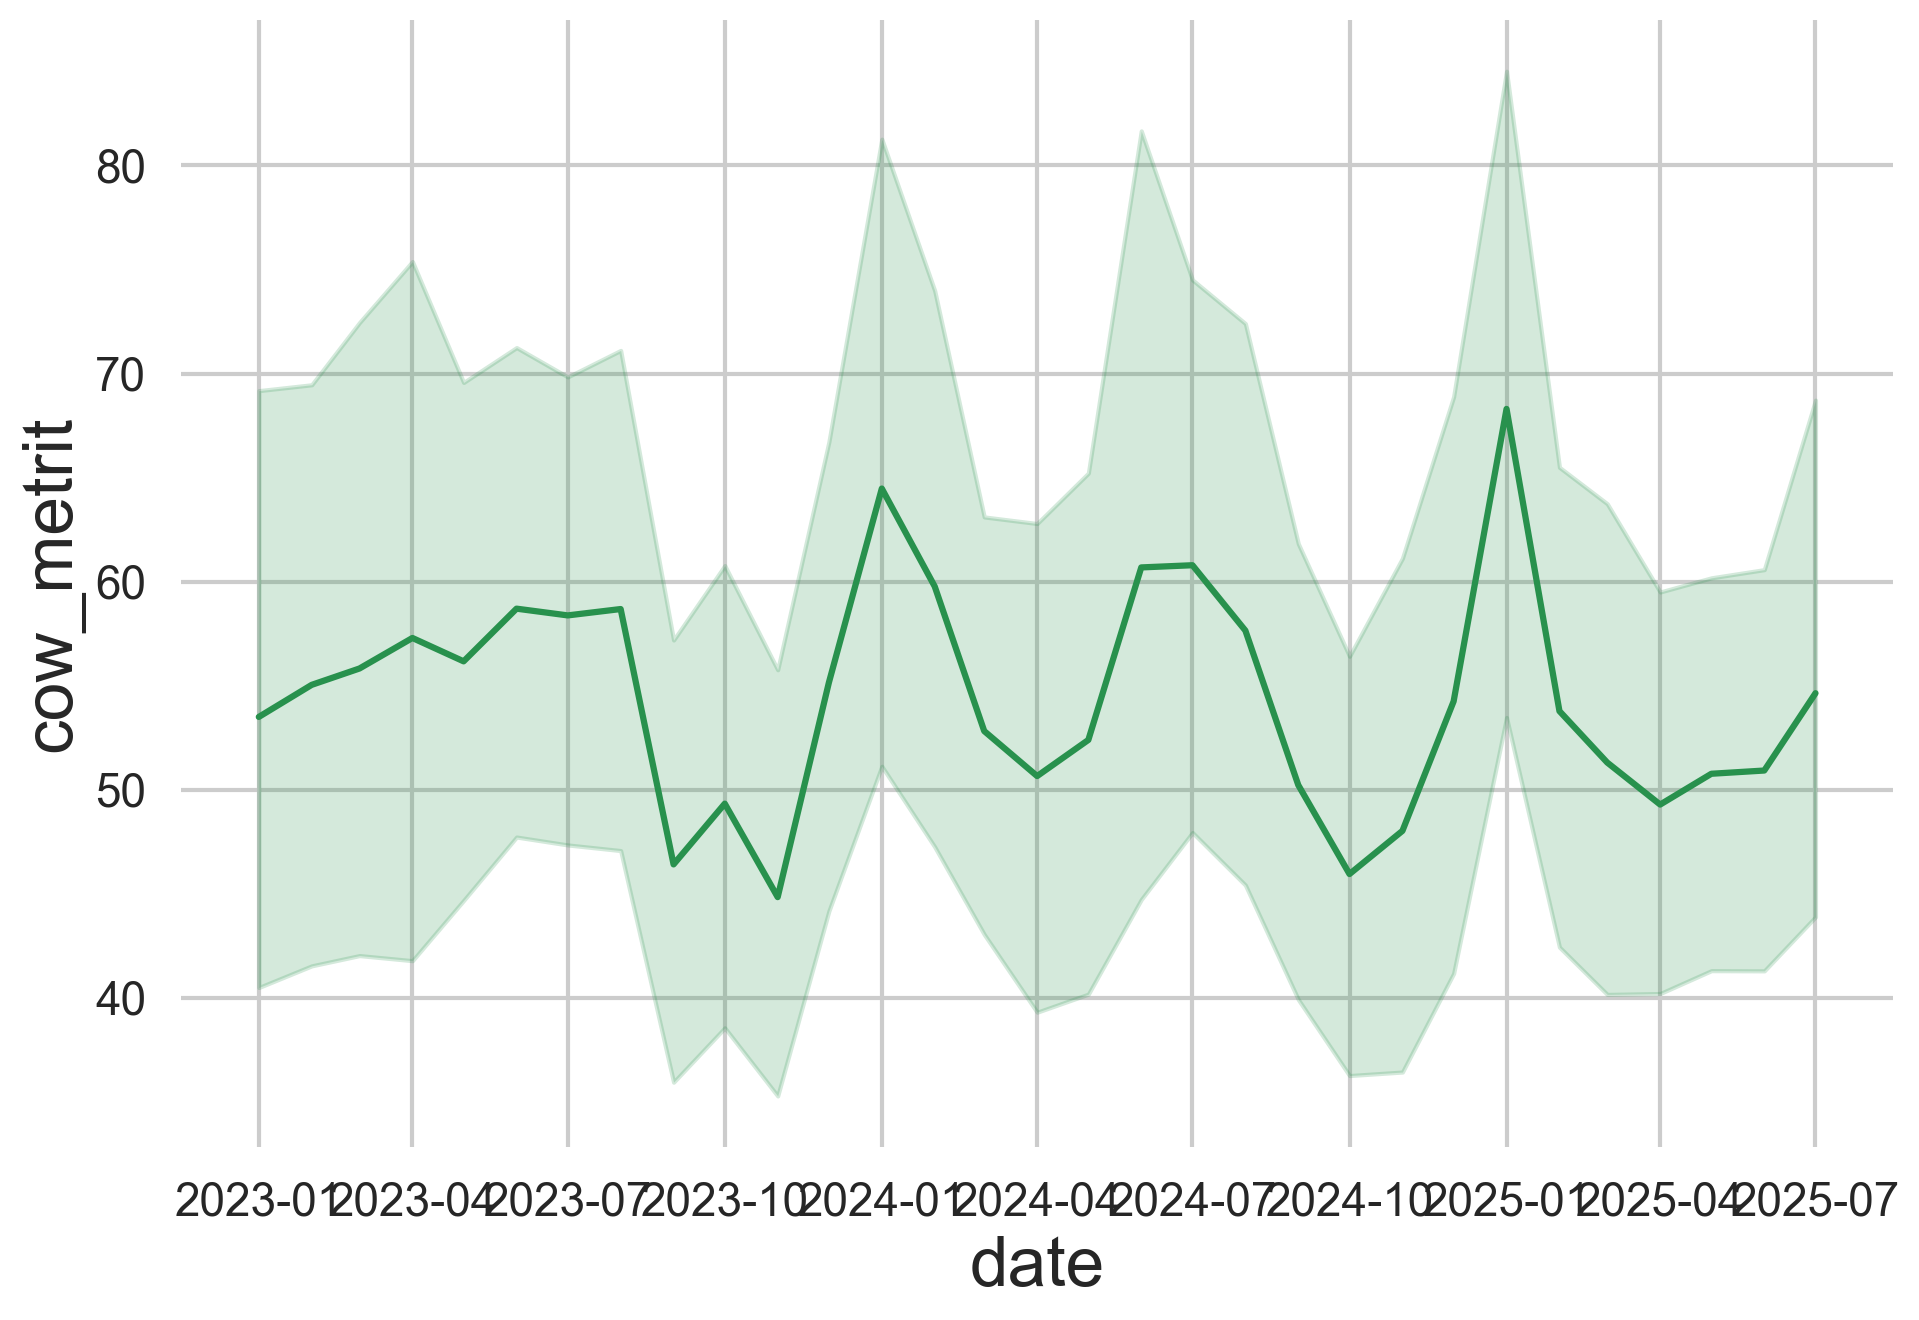

In [ ]:
sns.lineplot(df, x="date", y="cow_metrit")

In [ ]:
g = sns.FacetGrid(df, col="FarmName", col_wrap=4, sharey=False, height=3)
g.map_dataframe(sns.lineplot, x="date", y="cow_metrit")
g.set_titles("{col_name}")
g.set_axis_labels("date", "cow_metrit")
plt.tight_layout()
plt.show()


In [ ]:
g = sns.relplot(
    data=df,
    x="date",
    y="cow_metrit",
    col="FarmName",
    kind="line",
    col_wrap=4,
    height=3,
    facet_kws=dict(sharey=False)
)
plt.show()


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

for farm in df["FarmName"].unique():
    sub = df[df["FarmName"] == farm]

    plt.figure(figsize=(15,4))
    sns.lineplot(data=sub, x="date", y="cow_metrit", ci=False)
    plt.title(farm)
    plt.tight_layout()
    plt.show()
